In [32]:
# Instructions:
#
# model will need to run separately in batches:
#
#    LEVEL = 13, MAX_LEVEL = None  (1 hour train)
#    LEVEL = 14, MAX_LEVEL = None     ibid.
#    LEVEL = 15, MAX_LEVEL = None     ibid.
#    LEVEL = -1, MAX_LEVEL = 11    (~10 hour train)

# you could probably set MAX_LEVEL = 15 and train/infer all at once if you had 4x16GB RAM 

# to predict from saved models:
#    use each of the above settings with IMPORT = True; (runtime <10 minutes per run)

# the FINAL_BASE parameter determines whether to forecast the evaluation or validation period

# the SPEED = True flag reduces runtimes by 20x and appears to deliver identical performance (0.0% dif in CV)
# you may replicate the original submission by setting SPEED = False (200 hours training, 10 hours inference)

In [33]:
LEVEL = -1  # Level 13 is HOBBIES; Level 14 is HOUSEHOLD; Level 15 is FOODS (there is no "Level 12")
MAX_LEVEL = 9
IMPORT = False 

FINAL_BASE = ['d_1941', 'd_1913'][1]


SINGLE_FOLD = True
SPEED = True
SUPER_SPEED = False
REDUCED_FEATURES = False

sparse_features = ['dayofweek', 'dayofmonth', 
                     'qs_30d_ewm', 'qs_100d_ewm',
                    'qs_median_28d', 'qs_mean_28d',# 'qs_stdev_28d',
                    'state_id',
               #     'store_id',
                   'qs_qtile90_28d',
                    'pct_nonzero_days_28d',
                    'days_fwd'
                    ]

LEVEL_SPLITS = [(13, 'HOBBIES'), (14, 'HOUSEHOLD'), (15, 'FOODS')  ]
# ID_FILTER = '';   #  ['HOBBIES', 'HOUSEHOLD', 'FOODS', ]

In [34]:
QUANTILES = [0.005, 0.025, 0.165, 0.25, 0.5,  0.75, 0.835, 0.975, 0.995]  
# QUANTILES = [0.25, 0.5, 0.75]
# QUANTILES = [0.5]

In [35]:
P_DICT = \
    {1: (0.3, 0.7),   2: (0.1, 0.7),  3: (0.1, 0.5), 
     4: (0.3, 0.5),   5: (0.15, 1),    6: (0.2, 0.5),
     7: (0.1, 1),     8: (0.2, 0.5),    9: (0.1, 0.5),
    10: (0.05, 0.5), 11: (0.04, 1),  
    13: (0.12, 2),            14: (0.065, 2),          15: (0.03, 0.5)}
#     'HOBBIES': (0.12, 2), 'HOUSEHOLD': (0.065, 2), 'FOODS': (0.03, 0.5)}


SS_SS = 0.8    # 0.8 was production version ***

if SPEED or SUPER_SPEED or REDUCED_FEATURES:
    SS_SS /= (5 if SUPER_SPEED else (2 if SPEED else 1)) * (5 if REDUCED_FEATURES else 1)

In [36]:
BAGS = 1
N_JOBS = -1

SS_PWR = 0.6
BAGS_PWR = 0


In [37]:
# levels

In [38]:
FEATURE_DROPS = ['item_id', '_abs_diff', 'squared_diff' ]\
                +    ['336', '300d'] 


In [39]:
# run-time parameters
CACHED_FEATURES = False
CACHE_FEATURES = False


In [40]:
TIME_SEED = True

### Load Packages and Settings

In [41]:
!pip install lightgbm

In [42]:
import numpy as np  
import pandas as pd 

In [43]:
import psutil
import os

In [44]:
import pickle

In [45]:
from collections import Counter
import datetime as datetime
from scipy.stats.mstats import gmean
import random

In [46]:
import gc
import gzip
import bz2

In [47]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (17,5.5)
rcParams['figure.max_open_warning'] = 0
# %config InlineBackend.figure_format='retina'


In [48]:
import seaborn as sns


In [49]:
pd.options.display.max_rows = 150



In [50]:
start = datetime.datetime.now()



In [51]:
if TIME_SEED:
    np.random.seed(datetime.datetime.now().microsecond)

In [52]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def memCheck():
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                             key= lambda x: -x[1])[:10]:
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


In [53]:
def ramCheck():
    print("{:.1f} GB used".format(psutil.virtual_memory().used/1e9 - 0.7))


In [54]:
path = '/kaggle/input/m5-forecasting-uncertainty/'

In [55]:
path = 'm5-data'

In [56]:
ramCheck()


0.3 GB used


### Load and Aggregate Training Data

In [57]:
LEVELS = [(12, ['item_id', 'store_id']),
          (11, ['state_id', 'item_id']),
          (10, ['item_id']),
          (9, ['store_id', 'dept_id']),
          (8, ['store_id', 'cat_id']),
          (7, ['state_id', 'dept_id']),
          (6, ['state_id', 'cat_id']),
          (5, ['dept_id']),
          (4, ['cat_id']),
          (3, ['store_id']),
          (2, ['state_id']),
          (1, []) ]

DOWNSTREAM = {'item_id': ['dept_id', 'cat_id'],
              'dept_id': ['cat_id'],
              'store_id': ['state_id']}

In [58]:
def aggTrain(train):
    tcd = dict([(col, 'first') for col in train.columns[1:6]])
    tcd.update( dict([(col, 'sum') for col in train.columns[6:]]))

    tadds =[]; tadd_levels= [ [12 for i in range(0, len(train))] ] 
    for idx, lvl in enumerate(LEVELS[1:]):
        level = lvl[0]
        lvls = lvl[1]

        if len(lvls) is 0:  # group all if no list provided
            lvls = [1 for i in range(0, len(train))]

        tadd = train.groupby(lvls).agg(tcd)

        # name it
        if len(lvls) == 2:
            tadd.index = ['_'.join(map(str,i)) for i in tadd.index.tolist()]
        elif len(lvls) == 1:
            tadd.index = tadd.index + '_X'
        else:
            tadd.index = ['Total_X']
        tadd.index.name = 'id'

        # fill in categorical features
        tadd.reset_index(inplace=True)
        for col in [c for c in train.columns[1:6] if c not in lvls and not  
                            any(c in z for z in[DOWNSTREAM[lvl] for lvl in lvls if lvl in DOWNSTREAM])]:
            tadd[col] = 'All'
        tadds.append(tadd)

        #levels
        tadd_levels.append([level for i in range(0, len(tadd))])

    train = pd.concat((train,*tadds), sort=False, ignore_index=True); del tadds, tadd
    levels = pd.Series(data = [x for sub_list in tadd_levels for x in sub_list], index = train.index); del tadd_levels
    for col in train.columns[1:6]:
        train[col] = train[col].astype('category')
        
    return train, levels

In [59]:
def loadTrain():
    train_cols =  pd.read_csv(path+ '/' + 'sales_train_evaluation.csv', nrows=1)

    c_dict = {}
    for col in [c for c in train_cols if 'd_' in c]:
        c_dict[col] = np.float32

    train = pd.read_csv(path+ '/' + 'sales_train_evaluation.csv', dtype=c_dict)#.astype(np.int16, errors='ignore')

    train.id = train.id.str.split('_').str[:-1].str.join('_')
    
    train.sort_values('id', inplace=True)
    
    return train.reset_index(drop=True)

In [60]:
def getPricePivot():
    prices = pd.read_csv(path+ '/' + 'sell_prices.csv',
                    dtype = {'wm_yr_wk': np.int16, 'sell_price': np.float32})
    prices['id'] = prices.item_id + "_" + prices.store_id
    price_pivot =  prices.pivot(columns = 'id' , index='wm_yr_wk', values = 'sell_price')
    price_pivot = price_pivot.reindex(sorted(price_pivot.columns), axis=1)
    return price_pivot

In [61]:
def getCal():
    return pd.read_csv(path+ '/' + 'calendar.csv').set_index('d')

In [62]:
cal = getCal()
cal.date = pd.to_datetime(cal.date)

day_to_cal_index = dict([(col, idx) for idx, col in enumerate(cal.index)])
cal_index_to_day = dict([(idx, col) for idx, col in enumerate(cal.index)])

cal_index_to_wm_yr_wk = dict([(idx, col) for idx, col in enumerate(cal.wm_yr_wk)])
day_to_wm_yr_wk = dict([(idx, col) for idx, col in cal.wm_yr_wk.iteritems()])

In [63]:
# Load
train = loadTrain()
price_pivot = getPricePivot()

In [64]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  14 s


In [65]:
# combine
assert (train.id == price_pivot.columns).all()
daily_sales = pd.concat((train.iloc[:, :6], 
                        train.iloc[:, 6:] * price_pivot.loc[train.columns[6:].fillna(0)\
                                                                .map(day_to_wm_yr_wk)].transpose().values ), 
                            axis = 'columns')

In [66]:
# Aggregate
train, levels = aggTrain(train)
# id_to_level = dict(zip(train.id, levels))
# level_to_ids = dict([(level[0], list(train.id[levels == level[0]])) for idx, level in enumerate(LEVELS)])

daily_sales = aggTrain(daily_sales)[0]


In [67]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  40 s


In [68]:
# Rescale each level to avoid hitting np.half ceiling and keep similar ranges
level_multiplier = dict([ (c, (levels==c).sum() / (levels==12).sum()) for c in sorted(levels.unique())])

In [69]:
# split up level 12
for row in LEVEL_SPLITS:
    level_multiplier[row[0]] = level_multiplier[12]
    levels.loc[(levels == 12) & (train.cat_id == row[1])] = row[0]

In [70]:
Counter(levels)

Counter({15: 14370,
         13: 5650,
         14: 10470,
         11: 9147,
         10: 3049,
         9: 70,
         8: 30,
         7: 21,
         6: 9,
         5: 7,
         4: 3,
         3: 10,
         2: 3,
         1: 1})

In [71]:
# Rescale by number of series at each level
train = pd.concat((train.iloc[:, :6], 
                        train.iloc[:, 6:].multiply( levels.map(level_multiplier), axis = 'index').astype(np.float32) ), 
                            axis = 'columns')

daily_sales = pd.concat((daily_sales.iloc[:, :6], 
                        daily_sales.iloc[:, 6:].multiply( levels.map(level_multiplier), axis = 'index').astype(np.float32) ), 
                            axis = 'columns')


In [72]:
def loadSampleSub():
    return pd.read_csv(path+ '/' + 'sample_submission.csv').astype(np.int8, errors = 'ignore')

sample_sub = loadSampleSub()

assert set(train.id) == set(sample_sub.id.str.split('_').str[:-2].str.join('_'))

In [73]:
print(len(train))

42840


In [74]:
ramCheck()

1.8 GB used


In [75]:
# memCheck()

In [76]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  46 s


In [77]:
train_filter = (   
               ( ( MAX_LEVEL is not None )   & (levels <= MAX_LEVEL) )  | 
               (  ( MAX_LEVEL is None )  &  (levels == LEVEL) )
                 )
train = train[train_filter].reset_index(drop=True)
daily_sales = daily_sales[train_filter].reset_index(drop=True)
levels = levels[train_filter].reset_index(drop=True).astype(np.int8)

In [78]:
Counter(levels)

Counter({9: 70, 8: 30, 7: 21, 6: 9, 5: 7, 4: 3, 3: 10, 2: 3, 1: 1})

In [79]:
train.head()

id item_id    dept_id   cat_id store_id state_id       d_1  \
0    CA_1_FOODS_1     All    FOODS_1    FOODS     CA_1       CA  0.681863   
1    CA_1_FOODS_2     All    FOODS_2    FOODS     CA_1       CA  1.547393   
2    CA_1_FOODS_3     All    FOODS_3    FOODS     CA_1       CA  5.206953   
3  CA_1_HOBBIES_1     All  HOBBIES_1  HOBBIES     CA_1       CA  1.212201   
4  CA_1_HOBBIES_2     All  HOBBIES_2  HOBBIES     CA_1       CA  0.064283   

        d_2       d_3       d_4  ...    d_1932    d_1933    d_1934    d_1935  \
0  0.652017  0.491309  0.401771  ...  0.945884  0.998688  0.952771  0.635946   
1  1.503772  0.909151  1.092817  ...  1.251230  1.402755  1.793047  1.274188   
2  5.046245  3.209577  3.689406  ...  5.528370  6.887504  8.083634  5.431945   
3  1.122663  0.938996  0.879305  ...  1.253526  1.680551  1.448672  0.893080   
4  0.020663  0.013775  0.020663  ...  0.096425  0.169892  0.128567  0.064283   

     d_1936    d_1937    d_1938    d_1939    d_1940    d_1941  
0  0.693342  0.911446  0.757625  0.711709  0.980321  0.766809  
1  1.092817  0.980321  0.943588  0.996392  1.439488  1.650705  
2  4.628403  4.573303  4.851099  5.163332  6.265333  7.516563  
3  0.796655  0.810430  0.812725  1.134142  1.506068  1.349951  
4  0.105608  0.064283  0.119383  0.103313  0.144638  0.133158  

[5 rows x 1947 columns]

In [80]:
print(len(train))

154


In [81]:
train_head = train.iloc[:, :6]  

In [82]:
train_head.head()

id item_id    dept_id   cat_id store_id state_id
0    CA_1_FOODS_1     All    FOODS_1    FOODS     CA_1       CA
1    CA_1_FOODS_2     All    FOODS_2    FOODS     CA_1       CA
2    CA_1_FOODS_3     All    FOODS_3    FOODS     CA_1       CA
3  CA_1_HOBBIES_1     All  HOBBIES_1  HOBBIES     CA_1       CA
4  CA_1_HOBBIES_2     All  HOBBIES_2  HOBBIES     CA_1       CA

In [83]:
ramCheck()

1.2 GB used


In [84]:
# replace leading zeros with nan
train['d_1'].replace(0, np.nan, inplace=True)

for i in range(train.columns.get_loc('d_1') + 1, train.shape[1]):
    train.loc[:, train.columns[i]].where( ~ ((train.iloc[:,i]==0) & (train.iloc[:,i-1].isnull())),
                                         np.nan, inplace=True)

In [85]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  48 s


In [86]:
train.head(5)

id item_id    dept_id   cat_id store_id state_id       d_1  \
0    CA_1_FOODS_1     All    FOODS_1    FOODS     CA_1       CA  0.681863   
1    CA_1_FOODS_2     All    FOODS_2    FOODS     CA_1       CA  1.547393   
2    CA_1_FOODS_3     All    FOODS_3    FOODS     CA_1       CA  5.206953   
3  CA_1_HOBBIES_1     All  HOBBIES_1  HOBBIES     CA_1       CA  1.212201   
4  CA_1_HOBBIES_2     All  HOBBIES_2  HOBBIES     CA_1       CA  0.064283   

        d_2       d_3       d_4  ...    d_1932    d_1933    d_1934    d_1935  \
0  0.652017  0.491309  0.401771  ...  0.945884  0.998688  0.952771  0.635946   
1  1.503772  0.909151  1.092817  ...  1.251230  1.402755  1.793047  1.274188   
2  5.046245  3.209577  3.689406  ...  5.528370  6.887504  8.083634  5.431945   
3  1.122663  0.938996  0.879305  ...  1.253526  1.680551  1.448672  0.893080   
4  0.020663  0.013775  0.020663  ...  0.096425  0.169892  0.128567  0.064283   

     d_1936    d_1937    d_1938    d_1939    d_1940    d_1941  
0  0.693342  0.911446  0.757625  0.711709  0.980321  0.766809  
1  1.092817  0.980321  0.943588  0.996392  1.439488  1.650705  
2  4.628403  4.573303  4.851099  5.163332  6.265333  7.516563  
3  0.796655  0.810430  0.812725  1.134142  1.506068  1.349951  
4  0.105608  0.064283  0.119383  0.103313  0.144638  0.133158  

[5 rows x 1947 columns]

In [87]:
train_flipped = train.set_index('id', drop = True).iloc[:, 5:].transpose()

In [88]:
train_flipped.dtypes

id
CA_1_FOODS_1      float32
CA_1_FOODS_2      float32
CA_1_FOODS_3      float32
CA_1_HOBBIES_1    float32
CA_1_HOBBIES_2    float32
                   ...   
WI_3_X            float32
CA_X              float32
TX_X              float32
WI_X              float32
Total_X           float32
Length: 154, dtype: object

In [89]:
train_flipped.head()

id   CA_1_FOODS_1  CA_1_FOODS_2  CA_1_FOODS_3  CA_1_HOBBIES_1  CA_1_HOBBIES_2  \
d_1      0.681863      1.547393      5.206953        1.212201        0.064283   
d_2      0.652017      1.503772      5.046245        1.122663        0.020663   
d_3      0.491309      0.909151      3.209577        0.938996        0.013775   
d_4      0.401771      1.092817      3.689406        0.879305        0.020663   
d_5      0.417842      0.812725      3.434569        0.603805        0.011479   

id   CA_1_HOUSEHOLD_1  CA_1_HOUSEHOLD_2  CA_2_FOODS_1  CA_2_FOODS_2  \
d_1          0.828796          0.415546      0.932109      0.486717   
d_2          0.803542          0.390292      0.936701      0.521154   
d_3          0.640538          0.261725      0.546409      0.316825   
d_4          0.638242          0.282388      0.551000      0.399475   
d_5          0.447688          0.309938      0.505084      0.234175   

id   CA_2_FOODS_3  ...    TX_1_X    TX_2_X    TX_3_X    WI_1_X    WI_2_X  \
d_1      3.615940  ...  0.838308  1.263365  0.993768  0.886848  0.739915   
d_2      2.952443  ...  0.881273  1.291243  0.985897  0.719580  0.630371   
d_3      2.096097  ...  0.597573  0.895703  0.729747  0.512299  0.661856   
d_4      2.585110  ...  0.740571  0.968842  0.711381  0.410298  0.827156   
d_5      2.194818  ...  0.555592  0.817317  0.566087  0.000656  0.385372   

id     WI_3_X      CA_X      TX_X      WI_X   Total_X  
d_1  1.324369  1.396687  0.928632  0.885339  1.070220  
d_2  1.376845  1.358314  0.947524  0.818039  1.041292  
d_3  1.087898  0.994556  0.666907  0.678616  0.780026  
d_4  1.053132  1.086946  0.726238  0.687176  0.833454  
d_5  0.699246  0.976550  0.581699  0.325582  0.627944  

[5 rows x 154 columns]

In [90]:
train_flipped.max().sort_values(ascending=False)[::3000]

id
CA_3_FOODS_3    11.750082
dtype: float32

In [91]:
# memCheck()

In [92]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  49 s


In [93]:
ramCheck()

1.2 GB used


In [94]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  49 s


### Item-Store Features

In [95]:
features = []

In [96]:
# basic moving averages
if not CACHED_FEATURES:      
    for window in [3, 7, 15, 30, 100]:
        if REDUCED_FEATURES and window < 15: continue;
        features.append(('qs_{}d_ewm'.format(window), 
                         train_flipped.ewm(span=window, 
                                           min_periods = int(np.ceil(window ** 0.8))  ).mean().astype(np.half)))
 

In [97]:
store_avg_qs = train_flipped[train_flipped.columns[levels >= 12]].transpose()\
            .groupby(train_head.iloc[(levels >= 12).values].store_id.values).mean().fillna(1)
store_dept_avg_qs = train_flipped[train_flipped.columns[levels >= 12]].transpose()\
            .groupby(  ( train_head.iloc[(levels >= 12).values].store_id.astype(str) + '_'
                        + train_head.iloc[(levels >= 12).values].dept_id.astype(str)).values
                    ).mean().fillna(1)

In [98]:
store_avg_qs

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  ...  d_1932  d_1933  \
All   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
CA_1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
CA_2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
CA_3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
CA_4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
TX_1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
TX_2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
TX_3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
WI_1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
WI_2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   
WI_3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...     1.0     1.0   

      d_1934  d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
All      1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
CA_1     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
CA_2     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
CA_3     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
CA_4     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
TX_1     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
TX_2     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
TX_3     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
WI_1     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
WI_2     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
WI_3     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0  

[11 rows x 1941 columns]

In [99]:
# basic moving averages, after removing any store trends
scaled_sales = train_flipped / (store_avg_qs.loc[train.store_id].transpose().values); 

# if levels.min() == 12:
#     # get overall store and store-dept sales matched to this id;
#     store_avg_qs_matched = store_avg_qs.loc[train.store_id].transpose() 
#     store_dept_avg_qs_matched = store_dept_avg_qs.loc[train.store_id.astype(str) + '_'
#                                                   + train.dept_id.astype(str)
#                                                 ].transpose() 

#     store_avg_qs_matched.columns = train_flipped.columns
#     store_dept_avg_qs_matched.columns = train_flipped.columns

#     ratio = (store_avg_qs_matched.rolling(28).mean() / store_avg_qs_matched.rolling(56).mean() ) .fillna(1) - 1
#     ratio = ratio.clip ( ratio.stack().quantile(0.01), ratio.stack().quantile(0.99))
# #     features.append(('store_28d_58d_ratio',  ratio.astype(np.half)))

#     ratio = (store_dept_avg_qs_matched.rolling(28).mean() / store_dept_avg_qs_matched.rolling(56).mean() ) .fillna(1) - 1
#     ratio = ratio.clip ( ratio.stack().quantile(0.003), ratio.stack().quantile(0.997))

# #     features.append(('store_dept_28d_58d_ratio',  ratio.astype(np.half)))

#     del store_avg_qs_matched, store_dept_avg_qs_matched, ratio

del store_avg_qs, store_dept_avg_qs,

In [100]:
# moving average after store-level detrending
if not CACHED_FEATURES:
    for window in [3, 7, 15, 30, 100]:
        if REDUCED_FEATURES: continue;
        features.append(('qs_divbystore_{}d_ewm'.format(window), 
                         scaled_sales.ewm(span=window,
                                           min_periods = int(np.ceil(window ** 0.8))  ).mean().astype(np.half)))

In [101]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  50 s


In [102]:
# EWM % NONZERO DAYS
if not CACHED_FEATURES:
    tff0ne0 = train_flipped.fillna(0).ne(0)
    for window in [7, 14, 28, 28*2, 28*4,  ]:  
        if REDUCED_FEATURES and window != 28: continue;
        features.append( ('pct_nonzero_days_{}d'.format(window),
                         tff0ne0.rolling(window).mean().astype(np.half) ) )
    del tff0ne0

In [103]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  50 s


### Features for Both Sales and Scaled Sales

In [104]:
arrs = [train_flipped, scaled_sales, ] # sales_over_all]
labels = ['qs', 'qs_divbystore', ] #'qs_divbyall']

if REDUCED_FEATURES: arrs = arrs[0:1]

In [105]:
# basic lag features
if not CACHED_FEATURES:
    for lag in range(1, 10+1):
        if REDUCED_FEATURES: continue;
        features.append( ('qs_lag_{}d'.format(lag),
                              train_flipped.shift(lag).fillna(0).astype(np.half) ) )

In [106]:
# means and medians -- by week to avoid day of week effects

if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
        label = labels[idx]

        for window in [7, 14, 21, 28, 28*2, 28*4,  ]:  ## ** mean and median
            if REDUCED_FEATURES and window != 28: continue;
            features.append( ('{}_mean_{}d'.format(label, window), 
                          arr.rolling(window).mean().astype(np.half) )  )

            features.append( ('{}_median_{}d'.format(label, window), 
                          arr.rolling(window).median().astype(np.half) )  )
            
            print('{}: {}'.format(label,window))

        del arr

qs: 7
qs: 14
qs: 21
qs: 28
qs: 56
qs: 112
qs_divbystore: 7
qs_divbystore: 14
qs_divbystore: 21
qs_divbystore: 28
qs_divbystore: 56
qs_divbystore: 112


In [107]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  52 s


In [108]:
# stdev, skewness, and kurtosis
# ideally kurtosis and skewness should NOT be labeled qs_ as they are scale-invariant

if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
        label = labels[idx]
        for window in [7, 14, 28, 28*3, 28*6]:
            if REDUCED_FEATURES and window != 28: continue;
            print('{}: {}'.format(label,window))

            features.append( ('{}_stdev_{}d'.format(label, window), 
                                  arr.rolling(window).std().astype(np.half) )  )

            if window >= 10:
                if REDUCED_FEATURES: continue;
                features.append( ('{}_skew_{}d'.format(label, window), 
                                      arr.rolling(window).skew().astype(np.half) )  )

                features.append( ('{}_kurt_{}d'.format(label, window), 
                                      arr.rolling(window).kurt().astype(np.half) )  )

    del arr;

qs: 7
qs: 14
qs: 28
qs: 84
qs: 168
qs_divbystore: 7
qs_divbystore: 14
qs_divbystore: 28
qs_divbystore: 84
qs_divbystore: 168


In [109]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  53 s


In [110]:
# high and low quantiles (adding more seemed to hurt performance)

if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
        label = labels[idx]
        for window in [14, 28, 56]:
            if REDUCED_FEATURES and window != 28: continue;

            features.append( ('{}_qtile10_{}d'.format(label, window), 
                          arr.rolling(window).quantile(0.1).astype(np.half) )  )

            features.append( ('{}_qtile90_{}d'.format(label, window), 
                          arr.rolling(window).quantile(0.9).astype(np.half) )  )

            print('{}: {}'.format(label,window))
        del arr


qs: 14
qs: 28
qs: 56
qs_divbystore: 14
qs_divbystore: 28
qs_divbystore: 56


In [111]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  54 s


In [112]:
del arrs; del scaled_sales

In [113]:
ramCheck()

1.2 GB used


### Data Cleaning

In [114]:
# start after one year, remove anything with proximity to holiday months (given mid-year LB targets)
# also saves a lot of RAM/processing time 

def clean_df(fr):
    early_rows = cal[cal.year == cal.year.min()].index.to_list()
    holiday_rows = cal[cal.month.isin([10, 11, 12, 1])].index.to_list()
    delete_rows = early_rows + holiday_rows
    
    MIN_DAY = 'd_{}'.format(300)
    
    if 'd' in fr.columns: # d, series stack:
        fr = fr[fr.d >= day_to_cal_index[MIN_DAY]]
        fr = fr[~fr.d.isin([  day_to_cal_index[d] for d in delete_rows])]
        
        
    else:  # pivot table
        if MIN_DAY in fr.index:
            fr = fr.iloc[ fr.index.get_loc(MIN_DAY):, :]

        if len(delete_rows) > 0:
            fr = fr[~fr.index.isin(delete_rows)]
    
    return fr;

In [115]:
def clean_features(features):
    for idx, feat_row in enumerate(features):
        fr = feat_row[1]
        fr = clean_df(fr)

        if len(fr) < len(feat_row[1]):
            features[idx] = (features[idx][0], fr)  

In [116]:
ramCheck()

1.2 GB used


In [117]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  55 s


### Cache Loader

In [118]:
pickle_dir = '/kaggle/input/m5-e300/'

if CACHED_FEATURES:
    if 'features.pbz2' in os.listdir(pickle_dir):
        with bz2.BZ2File(pickle_dir + 'features.pbz2', 'r') as handle:
            features = pickle.load(handle)
    elif 'features.pgz' in os.listdir(pickle_dir):
        with gzip.GzipFile(pickle_dir + 'features.pgz', 'r') as handle:
            features = pickle.load(handle)
        

In [119]:
ramCheck()

1.2 GB used


In [120]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  55 s


### Clean Features

In [121]:
clean_features(features)

In [122]:
# clean_features(item_features)

In [123]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  56 s


In [124]:
ramCheck()

1.2 GB used


### Save Caches

In [125]:
if CACHE_FEATURES:
    with gzip.GzipFile('features.pgz', 'w') as handle:
        pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)
    os.path.getsize('features.pgz') / 1e9

In [126]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  56 s


In [127]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  56 s


### Calendar Features

In [128]:
cal_features = pd.DataFrame()

cal_features['dayofweek'] =  cal.date.dt.dayofweek.astype(np.int8)
cal_features['dayofmonth'] =  cal.date.dt.day.astype(np.int8)
cal_features['season'] =  cal.date.dt.month.astype(np.half)


### State Calendar Features

In [129]:
state_cal_features = []

In [130]:
snap_cols = [c for c in cal.columns if 'snap' in c]

state_cal_features.append( ( 'snap_day' , 
                                cal[snap_cols].astype(np.int8) ) )
state_cal_features.append( ( 'snap_day_lag_1' , 
                                cal[snap_cols].shift(1).fillna(0).astype(np.int8) ) )
state_cal_features.append( ( 'snap_day_lag_2' , 
                                cal[snap_cols].shift(2).fillna(0).astype(np.int8) ) )

In [131]:
state_cal_features.append( ( 'nth_snap_day',
            (cal[snap_cols].rolling(15, min_periods = 1).sum() * cal[snap_cols] ).astype(np.int8)  ) )

In [132]:
for window in [2, 5, 10, 30, 60]:
    state_cal_features.append( ('snap_{}d_ewm'.format(window),
                                    cal[snap_cols].ewm(span = window, adjust=False).mean().astype(np.half) ) )

In [133]:
# strip columns to match state_id
def snapRename(x):
    return x.replace('snap_', '')

for f in range(0, len(state_cal_features)):
    state_cal_features[f] = (state_cal_features[f][0],
                                state_cal_features[f][1].rename(snapRename, axis = 'columns')) 

In [134]:
# pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
#          left_index=True, right_index=True).groupby('event_name_2').mean()\
#                 .sort_values('total_sales', ascending=False)

### Holidays

In [135]:
for etype in [c for c in cal.event_type_1.dropna().unique()]:
    cal[etype.lower() + '_holiday'] = np.where(cal.event_type_1 == etype,
                                       cal.event_name_1,
                                               np.where(cal.event_type_2 == etype,
                                                    cal.event_name_2, 'None'))

for etype in [c for c in cal.event_type_1.dropna().unique()]:
    cal[etype.lower() + '_holiday'] = cal[etype.lower() + '_holiday'].astype('category')

### Price Features

In [136]:
def getPricePivot():
    prices = pd.read_csv(path+ '/' + 'sell_prices.csv',
                    dtype = {'wm_yr_wk': np.int16, 'sell_price': np.float32})
    prices['id'] = prices.item_id + "_" + prices.store_id
    price_pivot =  prices.pivot(columns = 'id' , index='wm_yr_wk', values = 'sell_price')
    return price_pivot


price_pivot = getPricePivot()

In [137]:
ramCheck()

1.8 GB used


In [138]:
# memCheck()

### Assemble Series-Features Matrix

#### Dicts

In [139]:
series_to_series_id = dict([(col, idx) for idx, col in enumerate(train_flipped.columns)])
series_id_to_series = dict([(idx, col) for idx, col in enumerate(train_flipped.columns)])
series_id_level = dict([(idx, col) for idx, col in enumerate(levels)])
series_level = dict(zip(train_flipped.columns, levels))

series_to_item_id = dict([(x[1].id, x[1].item_id) for x in train_head[['id', 'item_id']].iterrows()])


#### Features

In [140]:
for feature in features:
    assert feature[1].shape == features[0][1].shape

In [141]:
fstack = features[0][1].stack(dropna = False)
series_features = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16)  })
del fstack

In [142]:
for idx, feature in enumerate(features):
    if feature is not None:
        series_features[feature[0]] = feature[1].stack(dropna=False).values
        
del features 

In [143]:
ramCheck()

1.8 GB used


#### State Cal Features

In [144]:
for feature in state_cal_features:
    assert feature[1].shape == state_cal_features[0][1].shape

In [145]:
fstack = state_cal_features[0][1].stack(dropna = False)

In [146]:
state_cal_series_features = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'state': fstack.index.get_level_values(1)  })
del fstack

In [147]:
for idx, feature in enumerate(state_cal_features):
    if feature is not None:
        state_cal_series_features[feature[0]] = feature[1].stack(dropna=False).values
        

#### Clean Up NA

In [148]:
series_features.isnull().sum().sum()

0

In [149]:
series_features.fillna(-10, inplace=True)


#### Add Categoricals

In [150]:
CATEGORICALS = ['dept_id', 'cat_id', 'store_id', 'state_id', ] # 'item_id'] # never item_id; wrecks higher layers;

        
for col in CATEGORICALS:
    series_features[col] = series_features.series.map(series_id_to_series).map(
                train_head.set_index('id')[col]) #.astype('category')



In [151]:
ramCheck()

1.8 GB used


In [152]:
# memCheck()

In [153]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  67 s


### Metrics and Scaling

In [154]:
def addSuffix(c):
    return c + '_validation'

In [155]:
trailing_28d_sales = daily_sales.iloc[:,6:].transpose().rolling(28, min_periods = 1).sum().astype(np.float32)

fstack = train_flipped.stack(dropna = False)
weight_stack = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16),
                    'days_since_first': (~train_flipped.isnull()).expanding().sum().stack(dropna = False).values\
                                             .astype(np.int16),
                    'trailing_vol': ( (train_flipped.diff().abs()).expanding().mean() ).astype(np.float16)\
                                                 .stack(dropna = False).values,
                    'weights': (trailing_28d_sales / 
                                    trailing_28d_sales.transpose().groupby(levels).sum().loc[levels].transpose().values)
                                     .astype(np.float16)\
                                             .stack(dropna = False).values,
                            })

del fstack

In [156]:
del trailing_28d_sales; 

In [157]:
weight_stack.dtypes

d                     int16
series                int16
days_since_first      int16
trailing_vol        float16
weights             float16
dtype: object

In [158]:
new_items = weight_stack.days_since_first < 30
weight_stack[new_items].weights.sum() / weight_stack[weight_stack.days_since_first >= 0].weights.sum()
weight_stack.loc[new_items, 'weights'] = 0


In [159]:
ramCheck()

1.8 GB used


In [160]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  67 s


### Merge Weight and Y into Main Df

In [161]:
weight_stack = clean_df(weight_stack)

In [162]:
assert len(weight_stack) == len(series_features)
assert (weight_stack.d.values == series_features.d).all()
assert (weight_stack.series.values == series_features.series).all()

In [163]:
series_features = pd.concat( (series_features, 
                weight_stack.reset_index(drop=True).iloc[:, -2:]), axis = 1,)

In [164]:
weight_stack = weight_stack.iloc[:10, :]

In [165]:
fstack = train_flipped.stack(dropna = False)
y_full = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16),
                      'y': fstack.values})
del fstack

In [166]:
ramCheck()


1.8 GB used


In [167]:
# memCheck()

### Feature Merges to Build X/Y/etc.

In [168]:
def addMAcrosses(X):
    EWMS = [c for c in X.columns if 'ewm' in c and 'qs_' in c and len(c) < 12]
    for idx1, col1 in enumerate(EWMS):
        for idx2, col2 in enumerate(EWMS):
            if not idx1 < idx2:
                continue;
            
            X['qs_{}_{}_ewm_diff'.format(col1.split('_')[1], col2.split('_')[1])] = X[col1] - X[col2]
            X['qs_{}_{}_ewm_ratio'.format(col1.split('_')[1], col2.split('_')[1])] = X[col1] / X[col2]
                
    return X
    

In [169]:
def addCalFeatures(X):  # large block of code; easy;
    # day of week, month, season of year
    X['dayofweek'] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.dayofweek)
    X['dayofmonth'] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.dayofmonth)
 
    X['basedayofweek'] = X.d.map(cal_index_to_day).map(cal_features.dayofweek)
    X['dayofweekchg'] = (X.days_fwd % 7).astype(np.int8)

    X['basedayofmonth'] = X.d.map(cal_index_to_day).map(cal_features.dayofmonth)
    X['season'] =  ( ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.season) \
                             + np.random.normal( 0, 1, len(X)) ).astype(np.half)
                        # with a full month SD of noise to not overfit to specific days;

    # holidays
    holiday_cols = [c for c in cal.columns if '_holiday' in c]
    for col in holiday_cols:
        X['base_' + col] = X.d.map(cal_index_to_day).map(cal[col])
        X[col] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal[col])

    
    return X
#     'dayofweek'

In [170]:
def convertToLinearFeatures(X):
    X = X.copy()
    for s in X.dayofweek.unique():
        X['dayofweek_{}'.format(s)] = (X.dayofweek == s).astype(np.int8)
    X.drop( columns = X.columns[X.dtypes == 'category'], inplace=True)
    X['daysfwd_sqrt'] = (X.days_fwd ** 0.5).astype(np.half)
    
    return X

In [171]:
def addStateCalFeatures(X):  
    if (X.state_id == 'All').mean() > 0:
        print('No State Ids')
        return X;
    
    def rename_scf(c, name = 'basedate'):
        return c if (c=='d' or c == 'state') else name + '_' + c
    
    X['future_d'] = ( X.d + X.days_fwd)
    X['state'] = X.state_id.astype('object')
    
    nX = X.merge(state_cal_series_features[['state', 'd', 'snap_day', 'nth_snap_day']]
                 .rename(rename_scf, axis = 'columns'),
                                         on = ['d', 'state'],  
             validate='m:1', how = 'inner', suffixes = (False, False)) 
    
    
    nX = nX.merge(state_cal_series_features[['state', 'd', 'snap_day', 'nth_snap_day']]
                 .rename(columns = {'d': 'future_d'}), 
                                         on = ['future_d', 'state'],  
             validate='m:1', how = 'inner', suffixes = (False, False)) 
    
    nX.drop(columns = ['state', 'future_d'], inplace=True)
    
    assert len(nX) == len(X)
    
    
    
    return nX

In [172]:
def add_item_features(X):  
    return X


In [173]:
VALIDATION = -1; # 2016 # pure holdout from train and prediction sets;

In [174]:
def getXYG(X, scale_range = None, oos = False):
    start_time = datetime.datetime.now(); 

    # ensure it's in the train set, and days_forward is actually *forward*
    X.drop( X.index[ (X.days_fwd < 1) |
           (  ~oos  &  ( X.d + X.days_fwd > cal.index.get_loc(train_flipped.index[-1])  )    ) ], inplace=True)
    g = gc.collect()
    
    
    X = addMAcrosses(X)

    X = addCalFeatures(X)
    X = addStateCalFeatures(X)
    
    # noise to time-static features
    for col in [c for c in X.columns if 'store' in c and 'ratio' in c]:
        X[col] = X[col] + np.random.normal(0, 0.1, len(X))
        print('adding noise to {}'.format(col))
    

    # match with Y
    if 'y' not in X.columns:
        st = datetime.datetime.now(); 
        X['future_d'] = X.d + X.days_fwd
        if oos:  
            X = X.merge(y_full.rename(columns = {'d': 'future_d'}), on = ['future_d', 'series'], 
                             how = 'left')
            X.y = X.y.fillna(-1)
            
        else:  
            X = X.merge(y_full.rename(columns = {'d': 'future_d'}), on = ['future_d', 'series'],
                       )#    suffixes = (None, None), validate = 'm:1')
#     X['yo'] = X.y.copy()
    g = gc.collect()
    
    scaler_columns = [c for c in X.columns if c in weight_stack.columns[2:]]
    scalers = X[scaler_columns].copy()
    y = X.y
    
    groups = pd.Series(cal.iloc[(X.d + X.days_fwd)].year.values, X.index).astype(np.int16)
    
    
    # feature drops
    if REDUCED_FEATURES:
        feat_drops = [c for c in X.columns if c not in (sparse_features + ['d', 'series', 'days_fwd'])]
    
    elif len(FEATURE_DROPS) > 0:
        feat_drops = [c for c in X.columns if any(z in c for z in FEATURE_DROPS )]
        print('dropping {} features; anything containing {}'.format(len(feat_drops), FEATURE_DROPS))
        print('   -- {}'.format(feat_drops))
    else:
        feat_drops = []
        
    # final drops
    X.drop(columns = scaler_columns + (['future_d'] if 'future_d' in X.columns else []) + ['y'] + feat_drops , inplace=True)

    scalers['scaler'] = scalers.trailing_vol.copy()
    
    # randomize scaling
    if scale_range > 0:
        scalers.scaler = scalers.scaler * np.exp( scale_range * ( np.random.normal(0, 0.5, len(X))) )
#         scalers.scaler = scalers.scaler * np.exp( scale_range * ( np.random.rand(len(X)) - 0.5) )
    
    # now rescale y and  'scaled variable' in X by its vol
    for col in [c for c in X.columns if 'qs_' in c and 'ratio' not in c]:
        X[col] = np.where( X[col] == -10, X[col], (X[col] / scalers.scaler).astype(np.half)) 
    y = y / scalers.scaler
    
    
    yn = (oos == False) & (y.isnull() | (groups==VALIDATION)) 

    
    print("\nXYG Pull Time: {}".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
    
    return (X[~yn], y[~yn], groups[~yn], scalers[~yn])

In [175]:
def getSubsample(frac, level = 12, scale_range = 0.1, n_repeats = 1, drops = True, post_process_X = None):
    start_time = datetime.datetime.now(); 

    wtg_mean = series_features.weights[(series_features.series.map(series_id_level) == level)].mean()
    ss = series_features.weights / wtg_mean * frac
    
    X = series_features[  (ss > np.random.rand(len(ss)) ) 
                              & (series_features.series.map(series_id_level) == level) ]
    ss =  X.weights / wtg_mean   * frac 
      
    print('{} series that seek oversampling'.format( (ss > 1). sum() ) )
    print( ss[ss>1].sort_values()[-5:])
    
    extras = []
    
    while ss.max() > 1:
        ss = ss - 1
        extras.append( X[ ss > np.random.rand(len(ss))] )
        
    if len(extras) > 0:
        print(' scaled EWMS of extras:')
        print( ( extras[-1].qs_30d_ewm / extras[-1].trailing_vol)[-5:] )

    if len(extras) > 0:
        X = pd.concat((X, *extras))
    else:
        X = X.copy()
    
    
    X['days_fwd'] = (np.random.randint(0, 28, size = len(X)) + 1).astype(np.int8)
    
    if n_repeats > 1:
         X = pd.concat([X] * n_repeats)

    g = gc.collect()
    
    X, y, groups, scalers = getXYG(X, scale_range)
    ramCheck()
    g = gc.collect()
    if drops:
        X.drop(columns = ['d', 'series'], inplace=True)
    
    if post_process_X is not None:
        X = post_process_X(X)
    
    print(X.shape)
    print("\nSubsample Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))

    return X, y, groups, scalers

In [176]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  69 s


### Modeling

In [177]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import make_scorer
import lightgbm as lgb

In [178]:
def quantile_loss(true, pred, quantile = 0.5):
    loss = np.where(true >= pred, 
                        quantile*(true-pred),
                        (1-quantile)*(pred - true) )
    return np.mean(loss)   
 

In [179]:
def quantile_scorer(quantile = 0.5):
    return make_scorer(quantile_loss, False, quantile = quantile)

In [180]:
lgb_quantile_params = {     # fairly well tuned, with high runtimes 
                'max_depth': [10, 20],
                'n_estimators': [   200, 300, 350, 400, ],   
                'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
                'min_child_samples': [ 2, 4, 7, 10, 14, 20, 30, 40, 60, 80, 100, 130, 170, 200, 300, 500, 700, 1000 ],
                'min_child_weight': [0, 0, 0, 0, 1e-4, 1e-3, 1e-3, 1e-3, 5e-3, 2e-2, 0.1 ],
                'num_leaves': [ 20, 30, 30, 30, 50, 70, 90, ],
                'learning_rate': [  0.02, 0.03, 0.04, 0.04, 0.05, 0.05, 0.07, ],         
                'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
                'reg_lambda': [0, 0, 0, 0, 1e-5, 1e-5, 1e-5, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100   ],
                'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-4, 1e-3, 3e-3, 1e-2, 0.1, 1, 1, 10, 10, 100, 1000,],
                'subsample': [  0.9, 1],
                'subsample_freq': [1],
                'cat_smooth': [0.1, 0.2, 0.5, 1, 2, 5, 7, 10],
}

In [181]:
if SPEED or SUPER_SPEED or REDUCED_FEATURES:
    lgb_quantile_params = {     # fairly well tuned, with high runtimes 
                'max_depth': [10, 20],
                'n_estimators': [ 150, 200, 200],  # 300, 350, 400, ],   
                'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
                'min_child_samples': [ 2, 4, 7, 10, 14, 20, 30, 40, 60, 80, 100, 100, 100, 
                                                  130, 170, 200, 300, 500, 700, 1000 ],
                'min_child_weight': [0, 0, 0, 0, 1e-4, 1e-3, 1e-3, 1e-3, 5e-3, 2e-2, 0.1 ],
                'num_leaves': [ 20, 30, 50, 50 ], # 50, 70, 90, ],
                'learning_rate': [  0.04, 0.05, 0.07, 0.07, 0.07, 0.1, 0.1, 0.1 ],   # 0.02, 0.03,        
                'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
                'reg_lambda': [0, 0, 0, 0, 1e-5, 1e-5, 1e-5, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100   ],
                'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-4, 1e-3, 3e-3, 1e-2, 0.1, 1, 1, 10, 10, 100, 1000,],
                'subsample': [  0.9, 1],
                'subsample_freq': [1],
                'cat_smooth': [0.1, 0.2, 0.5, 1, 2, 5, 7, 10],
    }

In [182]:
def trainLGBquantile(x, y, groups, cv = 0, n_jobs = -1, alpha = 0.5, **kwargs):
    clfargs = kwargs.copy(); clfargs.pop('n_iter', None)
    clf = lgb.LGBMRegressor(verbosity=-1, hist_pool_size = 1000,  objective = 'quantile', alpha = alpha,
                            importance_type = 'gain',
                            seed = datetime.datetime.now().microsecond if TIME_SEED else None,
                             **clfargs,
                      )
    print('\n\n Running Quantile Regression for \u03BC={}\n'.format(alpha))
    params = lgb_quantile_params
    
    return trainModel(x, y, groups, clf, params, quantile_scorer(alpha), n_jobs, **kwargs)

In [183]:
def trainModel(x, y, groups, clf, params, cv = 0, n_jobs = None, 
                   verbose=0, splits=None, **kwargs):
    if n_jobs is None:
        n_jobs = -1
    folds = LeaveOneGroupOut()
    clf = RandomizedSearchCV(clf, params, cv=  folds, 
                             n_iter= ( kwargs['n_iter'] if len(kwargs) > 0 and 'n_iter' in kwargs else 4), 
                            verbose = 0, n_jobs = n_jobs, scoring = cv)
    f = clf.fit(x, y, groups)
    print(pd.DataFrame(clf.cv_results_['mean_test_score'])); print();  

    best = clf.best_estimator_;  print(best)
    print("\nBest In-Sample CV: {}\n".format(np.round(clf.best_score_,4)))

    return best

In [184]:
def runQBags(n_bags = 3, model_type = trainLGBquantile, data = None, quantiles = [0.5], **kwargs):
    start_time = datetime.datetime.now(); 
    
    clf_set = []; loss_set = []
    for bag in range(0, n_bags):
        print('\n\n  Running Bag {} of {}\n\n'.format(bag+1, n_bags))
        if data is None:
            X, y, groups, scalers = getSubsample()
        else:
            X, y, groups, scalers = data

        group_list = [*dict.fromkeys(groups)]   
        group_list.sort()
        print("Groups: {}".format(group_list))

        clfs = []; preds = []; ys=[]; datestack = []; losses = pd.DataFrame(index=QUANTILES)
        if SINGLE_FOLD: group_list = group_list[-1:]
        for group in group_list:
            print('\n\n   Running Models with {} Out-of-Fold\n\n'.format(group))
            x_holdout = X[groups == group]
            y_holdout = y[groups == group]
            
            ramCheck()
            model = model_type 
            
            q_clfs = []; q_losses = []
            for quantile in quantiles:
                set_filter = (groups != group) \
                        & (np.random.rand(len(groups)) < 
                                 quantile_wts[quantile] ** (0.35 if LEVEL >=11 else 0.25) )
                clf = model(X[set_filter], y[set_filter], groups[set_filter], 
                                alpha = quantile, **kwargs) 
                q_clfs.append(clf)

                predicted = clf.predict(x_holdout)

                q_losses.append((quantile, quantile_loss(y_holdout, predicted, quantile)))
                print(u"{} \u03BC={:.3f}: {:.4f}".format(group, quantile, q_losses[-1][1] ) )
                
                preds.append(predicted)
                ys.append(y_holdout)
            
            clfs.append(q_clfs)
            print("\nLevel {} OOS Losses for Bag {} in {}:".format(level, bag+1, group))
            print(np.round(pd.DataFrame(q_losses).set_index(0)[1], 4))
            losses[group] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values
            print("\nElapsed Time So Far This Bag: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
            
        
        clf_set.append(clfs)
        print("\nLevel {} Year-by-Year OOS Losses for Bag {}:".format(level, bag, group))
        print(losses)
        
        loss_set.append(losses)
        print("\nModel Bag Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
    return clf_set, loss_set

In [185]:
level_os = dict([(idx, 1/val) for (idx,val) in level_multiplier.items()])


In [186]:
# these are to use less processing time on edge quantiles 
QUANTILE_LEVELS = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
QUANTILE_WTS = [0.1, 0.2, 0.6, 0.8, 1, 0.9, 0.7, 0.2, 0.1,]
    
quantile_wts = dict(zip(QUANTILE_LEVELS, QUANTILE_WTS))

In [187]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  70 s


### Actually Run Model

In [188]:
if not IMPORT:
    clf_set = {}; loss_set = {}; LEVEL_QUANTILES = {};
    for level in sorted(levels.unique()):
        print("\n\n\nRunning Models for Level {}\n\n\n".format(level))
        
        SS_FRAC, SCALE_RANGE = P_DICT[level] # if level < 12 else ID_FILTER]; 
        SS_FRAC = SS_FRAC * SS_SS
        print('{}/{}'.format(SS_FRAC, SCALE_RANGE))
        
        # much higher iteration counts for low levels
        clf_set[level], loss_set[level] = runQBags(n_bags = int(BAGS * level_os[level] ** BAGS_PWR), 
                                                   model_type = trainLGBquantile, 
                                                   data = getSubsample(SS_FRAC * level_os[level] ** SS_PWR, 
                                                                       level, SCALE_RANGE),
                                                        n_iter =  int( 
                                                                 (2.2 if level <= 9 else 1.66) 
                                                                   * (16 - (level if level <=12 else 12) ) 
                                                                    * (1/4 if SUPER_SPEED else (1/2 if SPEED else 1))   
                                                                     ) ,
                      quantiles = QUANTILES,
                       n_jobs = N_JOBS) 
        
        LEVEL_QUANTILES[level] = QUANTILES





Running Models for Level 1



0.12/0.7
1081 series that seek oversampling
56517     58.84375
56671     58.84375
56825     58.84375
54669     58.84375
166473    58.84375
Name: weights, dtype: float16
 scaled EWMS of extras:
165857    10.242188
166011    10.140625
166165    10.132812
166319    10.250000
166473    10.406250
dtype: float16
No State Ids
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
1.5 GB used
(61979, 126)

Subsample Time: 0:00:01



  Running Bag 1 of 1


Groups: [2012, 2013, 2014, 2015, 2016]


   Running Models with 2016 Out-of-Fold


1.5 GB used


 Running Quantile Regression for μ=0.005

           0
0  -0.013525
1  -0.018119
2  -0.018664
3  -0.013098
4  -0.013619
5  -0.036683
6  -0.016684
7  -0.013387
8  -0.013733
9  -0.013252
10 -0.036269
11 -0.016819
12 -0.012763
13 -0.014142
14 -0.013131
15 -0.019296

LGBMRegressor(alpha=0.005, boosting_type='gbdt', cat_smooth=2,
              cl

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


           0
0  -0.287810
1  -0.210246
2  -0.208376
3  -0.286022
4  -0.216423
5  -0.207223
6  -0.211731
7  -0.207274
8  -0.287646
9  -0.208736
10 -0.206358
11 -0.209542
12 -0.208680

LGBMRegressor(alpha=0.25, boosting_type='gbdt', cat_smooth=0.2,
              class_weight=None, colsample_bynode=0.8, colsample_bytree=1,
              hist_pool_size=1000, importance_type='gain', learning_rate=0.1,
              max_depth=10, min_child_samples=100, min_child_weight=0.001,
              min_split_gain=0, n_estimators=150, n_jobs=-1, num_leaves=30,
              objective='quantile', random_state=None, reg_alpha=1e-05,
              reg_lambda=1e-05, seed=313713, silent=True, subsample=0.9,
              subsample_for_bin=200000, subsample_freq=1, verbosity=-1)

Best In-Sample CV: -0.2064

2016 μ=0.250: 0.1946


 Running Quantile Regression for μ=0.5

           0
0  -0.270186
1  -0.262769
2  -0.259394
3  -0.353377
4  -0.261014
5  -0.255443
6  -0.260885
7  -0.286633
8  -0.270876
9  -0.2621

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


           0
0  -0.224802
1  -0.223523
2  -0.226245
3  -0.224703
4  -0.223041
5  -0.222218
6  -0.317082
7  -0.222189
8  -0.221167
9  -0.222710
10 -0.226943

LGBMRegressor(alpha=0.25, boosting_type='gbdt', cat_smooth=5, class_weight=None,
              colsample_bynode=1, colsample_bytree=0.9, hist_pool_size=1000,
              importance_type='gain', learning_rate=0.07, max_depth=20,
              min_child_samples=60, min_child_weight=0.001, min_split_gain=0,
              n_estimators=200, n_jobs=-1, num_leaves=30, objective='quantile',
              random_state=None, reg_alpha=0, reg_lambda=1, seed=588008,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=1, verbosity=-1)

Best In-Sample CV: -0.2212

2016 μ=0.250: 0.2212


 Running Quantile Regression for μ=0.5

           0
0  -0.283615
1  -0.281998
2  -0.292080
3  -0.288394
4  -0.287444
5  -0.288137
6  -0.285107
7  -0.287561
8  -0.288622
9  -0.284583
10 -0.385438

LGBMRegressor(alpha

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


          0
0 -0.015638
1 -0.016674
2 -0.018317
3 -0.015350
4 -0.015305
5 -0.015964
6 -0.015874
7 -0.015593

LGBMRegressor(alpha=0.005, boosting_type='gbdt', cat_smooth=10,
              class_weight=None, colsample_bynode=0.65, colsample_bytree=0.8,
              hist_pool_size=1000, importance_type='gain', learning_rate=0.04,
              max_depth=20, min_child_samples=1000, min_child_weight=0.001,
              min_split_gain=0, n_estimators=200, n_jobs=-1, num_leaves=50,
              objective='quantile', random_state=None, reg_alpha=0.1,
              reg_lambda=0.01, seed=399031, silent=True, subsample=0.9,
              subsample_for_bin=200000, subsample_freq=1, verbosity=-1)

Best In-Sample CV: -0.0153

2016 μ=0.005: 0.0175


 Running Quantile Regression for μ=0.025

          0
0 -0.054159
1 -0.051760
2 -0.053009
3 -0.052721
4 -0.089406
5 -0.057667
6 -0.053340
7 -0.052597

LGBMRegressor(alpha=0.025, boosting_type='gbdt', cat_smooth=5,
              class_weight=None, colsa

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


          0
0 -0.201655
1 -0.210194
2 -0.206633
3 -0.202984
4 -0.203920
5 -0.203734
6 -0.207671
7 -0.200945

LGBMRegressor(alpha=0.165, boosting_type='gbdt', cat_smooth=0.5,
              class_weight=None, colsample_bynode=0.9, colsample_bytree=1,
              hist_pool_size=1000, importance_type='gain', learning_rate=0.1,
              max_depth=20, min_child_samples=500, min_child_weight=0.0001,
              min_split_gain=0.01, n_estimators=200, n_jobs=-1, num_leaves=30,
              objective='quantile', random_state=None, reg_alpha=0.0001,
              reg_lambda=10, seed=890758, silent=True, subsample=0.9,
              subsample_for_bin=200000, subsample_freq=1, verbosity=-1)

Best In-Sample CV: -0.2009

2016 μ=0.165: 0.2015


 Running Quantile Regression for μ=0.25

          0
0 -0.259938
1 -0.258657
2 -0.260469
3 -0.263908
4 -0.266122
5 -0.257889
6 -0.261339
7 -0.320007

LGBMRegressor(alpha=0.25, boosting_type='gbdt', cat_smooth=0.2,
              class_weight=None, cols

In [189]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  6398 s


### Import Classifiers

In [190]:
if IMPORT:
    clf_sets = []  # ***
    path = '/kaggle/input/m5clfs/'
    
   # if LEVEL != 12: 
    files = [f for f in os.listdir(path) if '.pkl' in f]
    if LEVEL == 13 and MAX_LEVEL is None: files = [f for f in files if '13_' in f or 'hobbies' in f]
    if LEVEL == 14 and MAX_LEVEL is None: files = [f for f in files if '14_' in f or 'household' in f]
    if LEVEL == 15 and MAX_LEVEL is None: files = [f for f in files if '15_' in f or 'foods' in f]      
        
  #  else:
  #      files = [f for f in os.listdir(path) if '.pkl' in f and ID_FILTER.lower() in f]
        
    for file in files:
        clf_sets.append(pickle.load(open(path + file,'rb')))
 
    clf_df = []; pairs = []
    for clf_set in clf_sets:
        for level, level_clfs in clf_set.items():
            for clf_bag_idx, clf_bag in enumerate(level_clfs):
                for group_idx, clf_group in enumerate(clf_bag):
                    for quantile_idx, clf in enumerate(clf_group):
                        clf_df.append((level, clf.alpha, group_idx, clf))


    clf_df = pd.DataFrame(clf_df, columns = ['level', 'alpha', 'group', 'clf'])
    
    if LEVEL > 12 and MAX_LEVEL == None:
        clf_df.loc[clf_df.level==12, 'level'] = LEVEL


    # clf_df
    
    LEVEL_QUANTILES = {}; clf_set = {}
    for level in sorted(clf_df.level.unique()):

        level_df = clf_df[clf_df.level == level]

        level_list = []
        for group in sorted(level_df.group.unique()):
            group_df = level_df[level_df.group == group].sort_values('alpha')
            if level in LEVEL_QUANTILES:
                assert LEVEL_QUANTILES[level] == list(group_df.alpha)
            else:
                LEVEL_QUANTILES[level] = list(group_df.alpha)
            level_list.append(list(group_df.clf))
        if len(level_df.group.unique()) > 1:
            SINGLE_FOLD = False
        clf_set[level] = [level_list]
        print(level, ": ", LEVEL_QUANTILES[level]); 

In [191]:
# LEVEL

### Display

In [192]:
for level in sorted(clf_set.keys()):
    print("Level {}:".format(level))
    
    for idx, q in enumerate(LEVEL_QUANTILES[level]):
        print(u'\n\n      Regressors for \u03BC={}:\n'.format(q))
        for clf in [q_clfs[idx] for clfs in clf_set[level] for q_clfs in clfs]:
            print(clf)
    
    print(); print()


Level 1:


      Regressors for μ=0.005:

LGBMRegressor(alpha=0.005, boosting_type='gbdt', cat_smooth=2,
              class_weight=None, colsample_bynode=0.8, colsample_bytree=1,
              hist_pool_size=1000, importance_type='gain', learning_rate=0.1,
              max_depth=20, min_child_samples=200, min_child_weight=0,
              min_split_gain=0.0001, n_estimators=200, n_jobs=-1, num_leaves=30,
              objective='quantile', random_state=None, reg_alpha=3e-05,
              reg_lambda=1e-05, seed=954764, silent=True, subsample=1,
              subsample_for_bin=200000, subsample_freq=1, verbosity=-1)


      Regressors for μ=0.025:

LGBMRegressor(alpha=0.025, boosting_type='gbdt', cat_smooth=0.1,
              class_weight=None, colsample_bynode=0.2, colsample_bytree=1,
              hist_pool_size=1000, importance_type='gain', learning_rate=0.1,
              max_depth=20, min_child_samples=300, min_child_weight=0.001,
              min_split_gain=0.1, n_estimators=20

In [193]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  6398 s


In [194]:
# save classifiers
clf_file = ('clf_set.pkl' if IMPORT 
                          else ('lvl_{}_clfs.pkl'.format(LEVEL) if MAX_LEVEL == None 
                                                            else 'lvls_lt_{}_clfs.pkl'.format(MAX_LEVEL)))
with open(clf_file, 'wb') as handle:
    pickle.dump(clf_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [195]:
ramCheck()

3.1 GB used


### Feature Importance

In [196]:
def show_FI(model, featNames, featCount):
   # show_FI_plot(model.feature_importances_, featNames, featCount)
    fis = model.feature_importances_
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(fis)[::-1][:featCount]
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fis[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title( " feature importance")
    

In [197]:
def avg_FI(all_clfs, featNames, featCount, title = "Feature Importances"):
    # 1. Sum
    clfs = []
    for clf_set in all_clfs:
        for clf in clf_set:
            clfs.append(clf);
    fi = np.zeros( (len(clfs), len(clfs[0].feature_importances_)) )
    for idx, clf in enumerate(clfs):
        fi[idx, :] = clf.feature_importances_
    avg_fi = np.mean(fi, axis = 0)

    # 2. Plot
    fis = avg_fi
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(fis)[::-1]#[:featCount]
    #print(indices)
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fis[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title(title + ' - {} classifiers'.format(len(clfs)))
    
    return pd.Series(fis[indices], featNames[indices])

In [198]:
def linear_FI_plot(fi, featNames, featCount):
   # show_FI_plot(model.feature_importances_, featNames, featCount)
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(np.absolute(fi))[::-1]#[:featCount]
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fi[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title( " feature importance")
    return pd.Series(fi[indices], featNames[indices])

0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
3.1 GB used
(0, 130)

Subsample Time: 0:00:00

Level 1:


0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
3.1 GB used
(0, 130)

Subsample Time: 0:00:00

Level 2:


0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
3.1 GB used
(1, 130)

Subsample Time: 0:00:00

Level 3:


0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
3.1 GB use

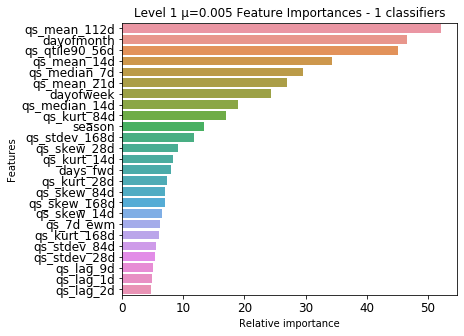

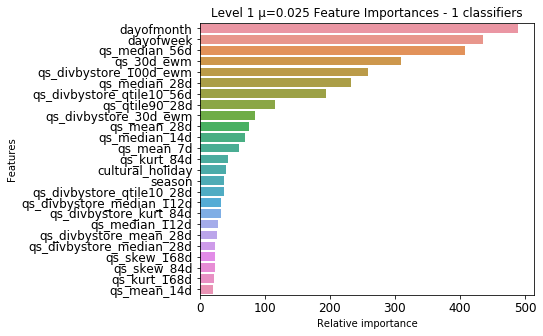

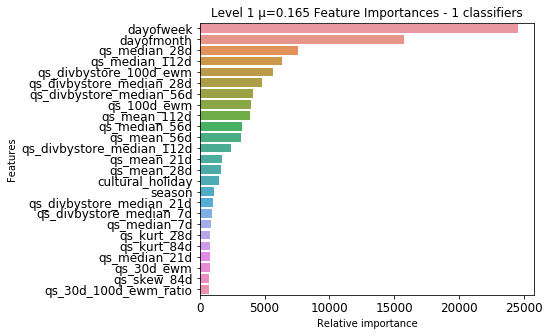

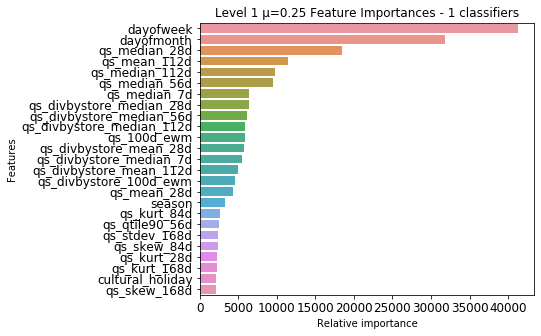

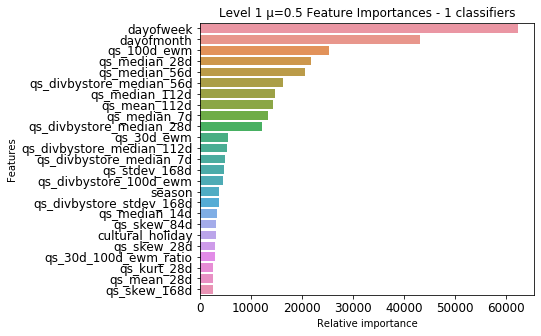

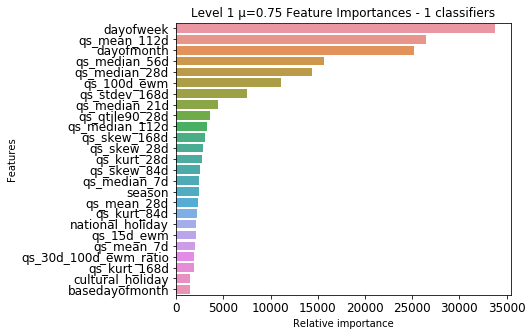

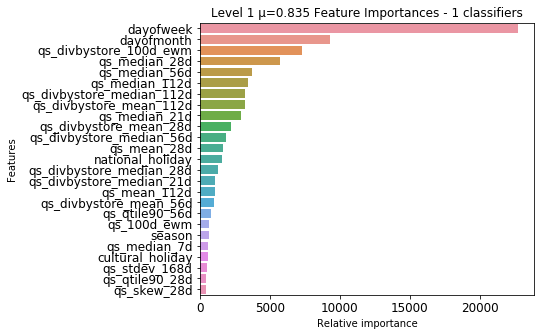

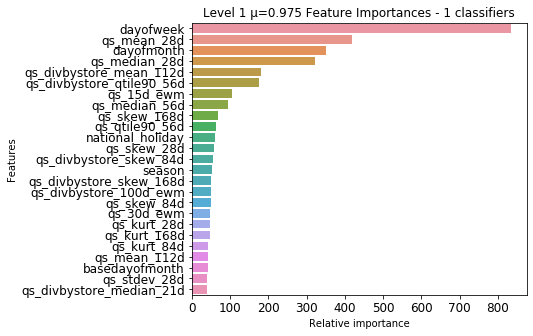

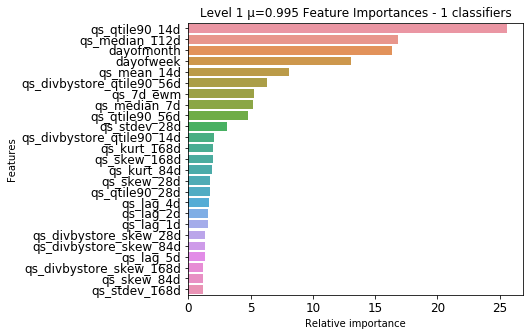

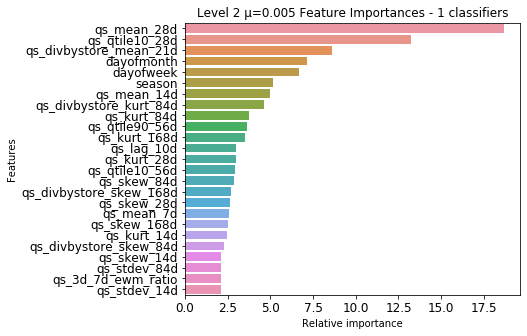

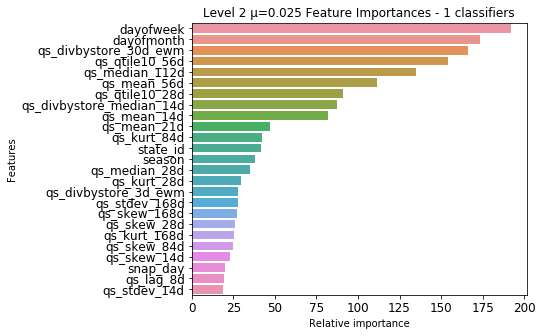

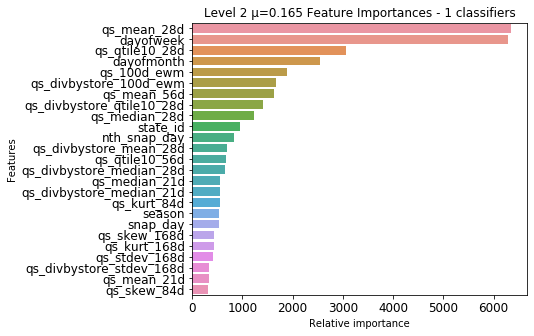

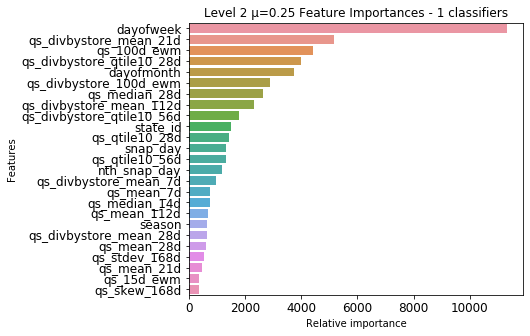

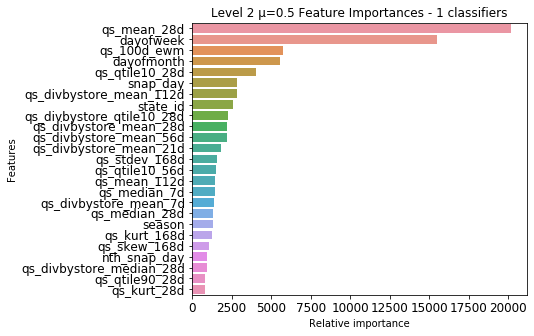

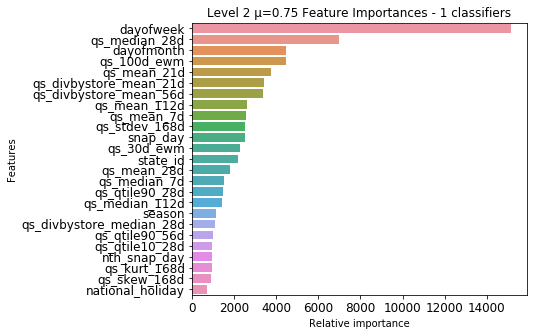

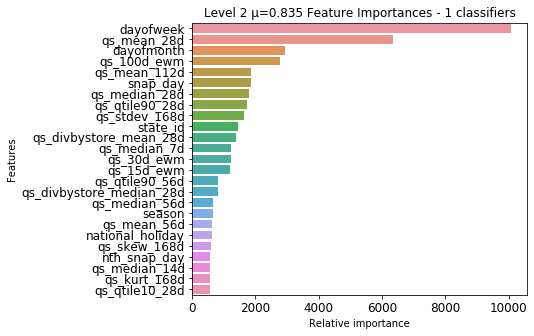

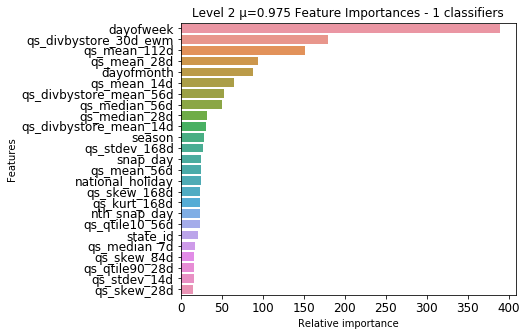

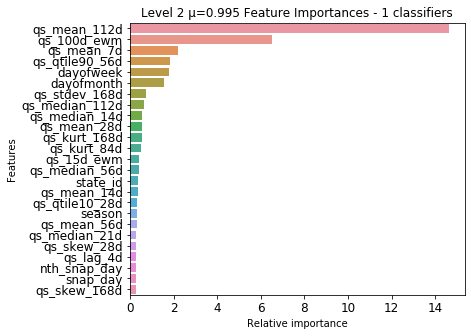

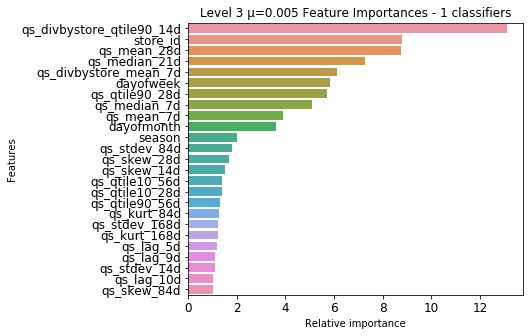

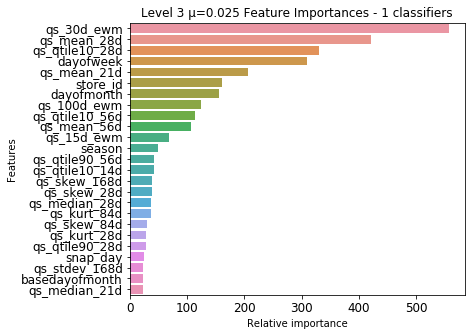

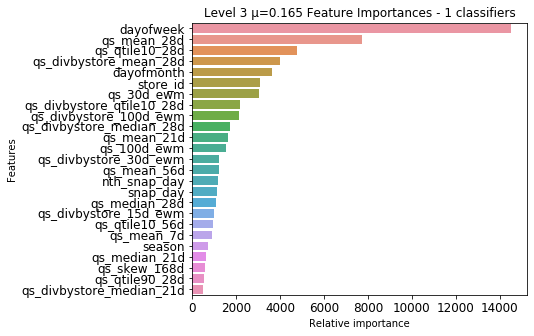

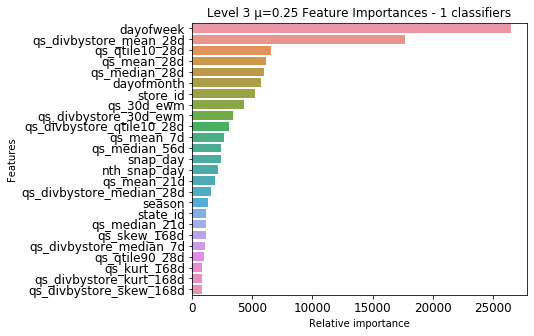

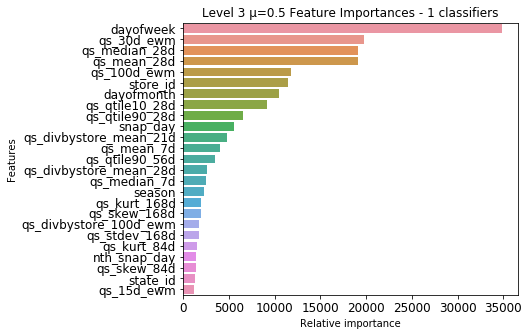

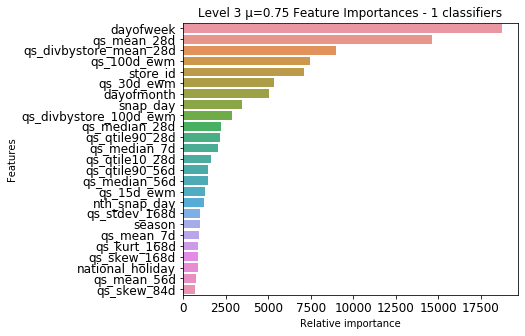

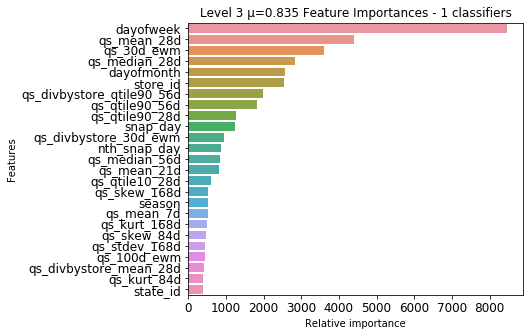

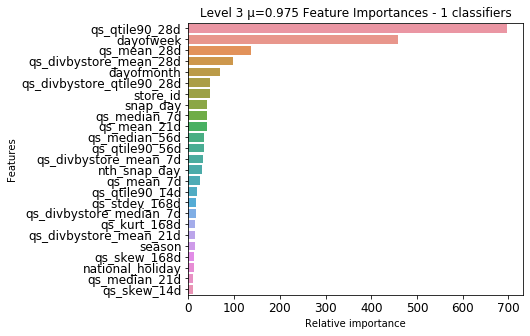

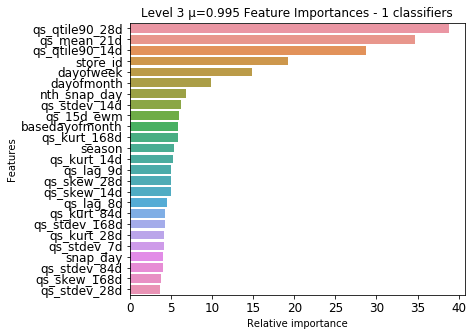

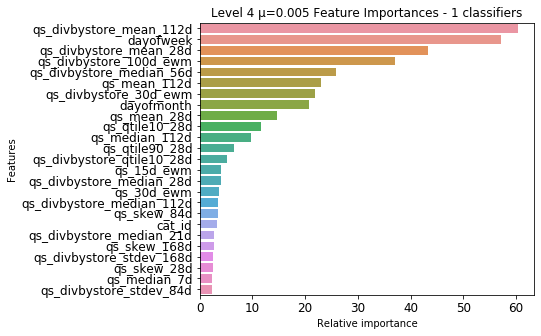

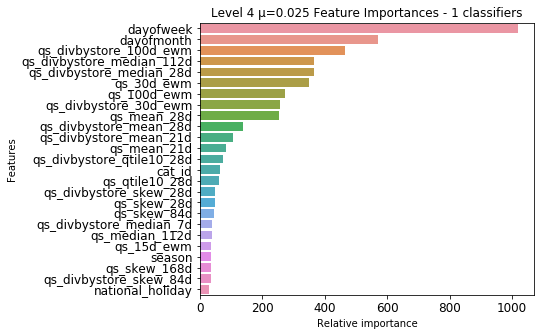

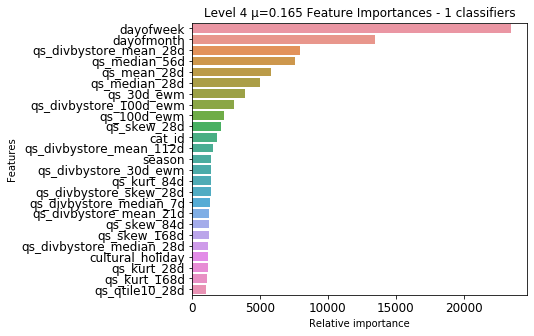

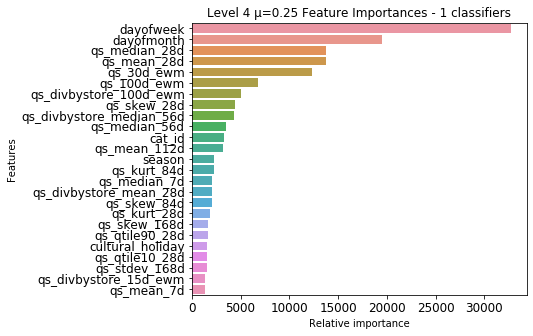

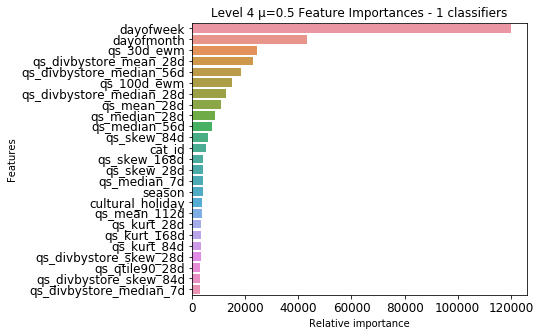

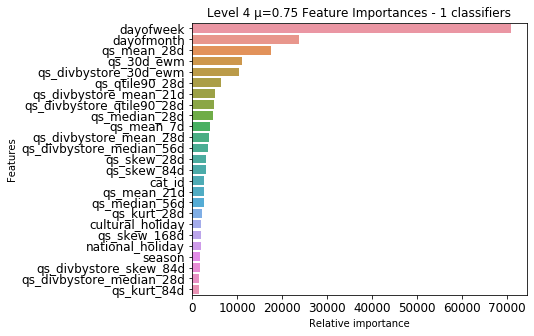

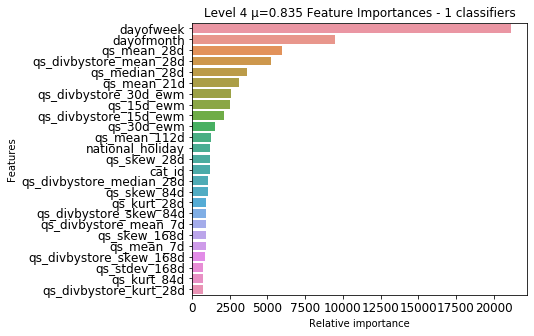

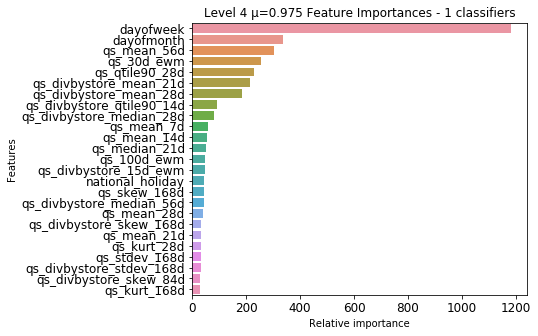

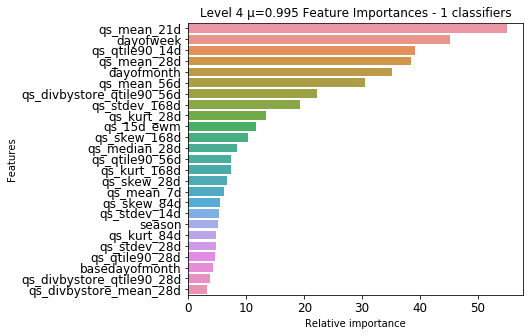

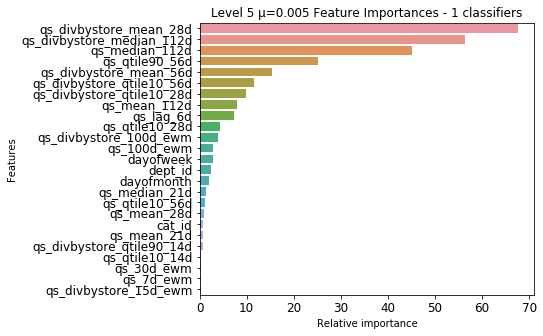

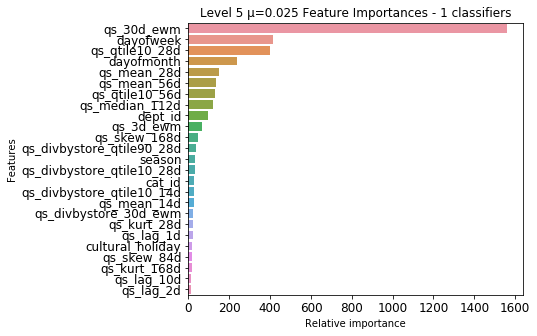

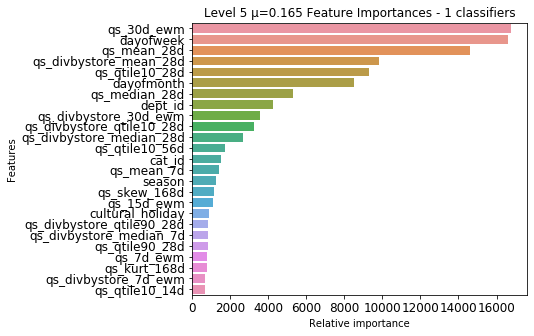

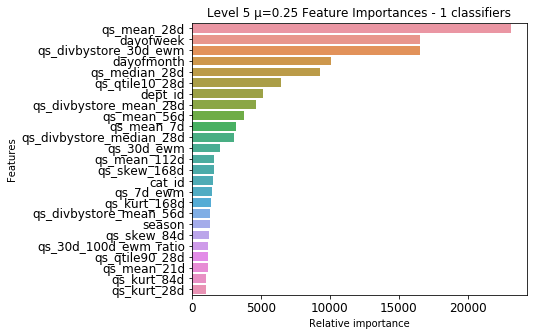

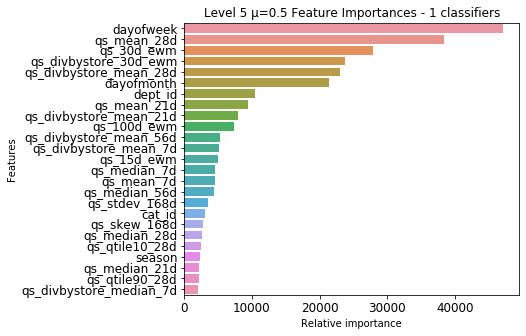

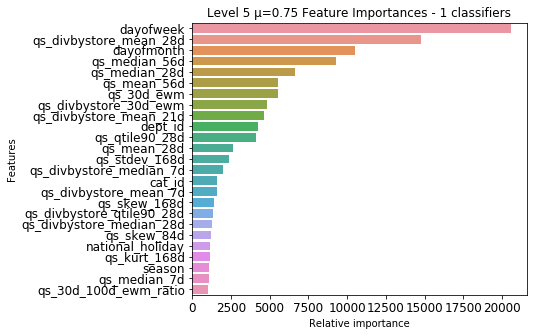

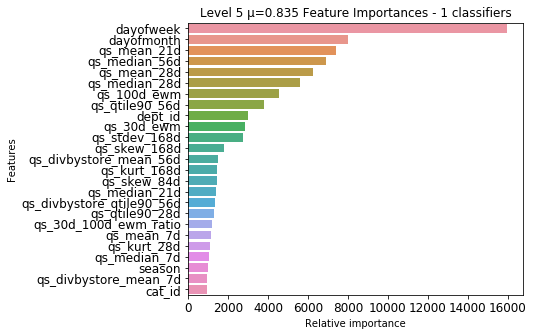

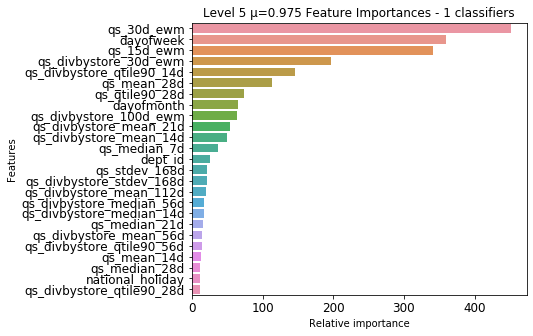

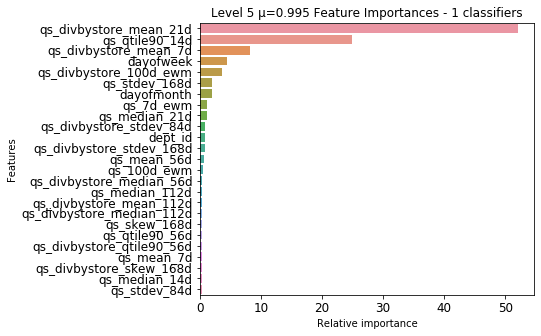

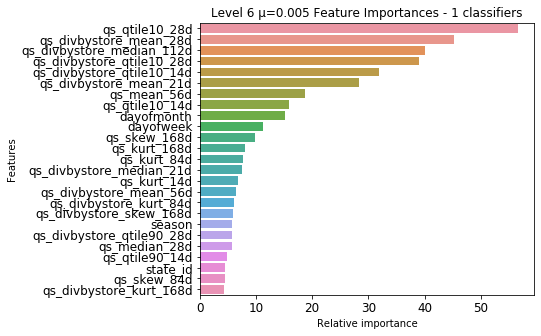

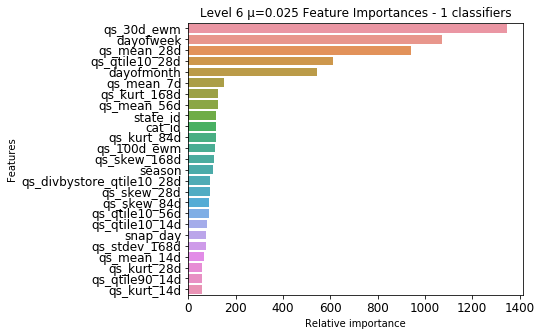

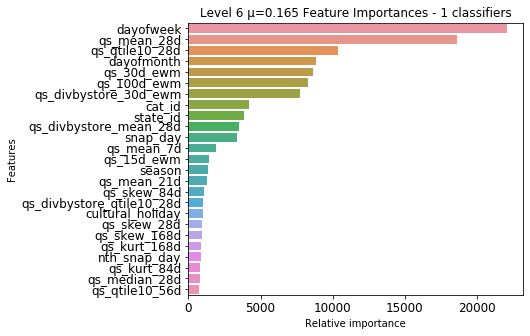

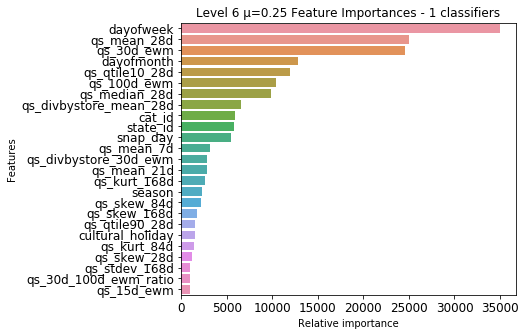

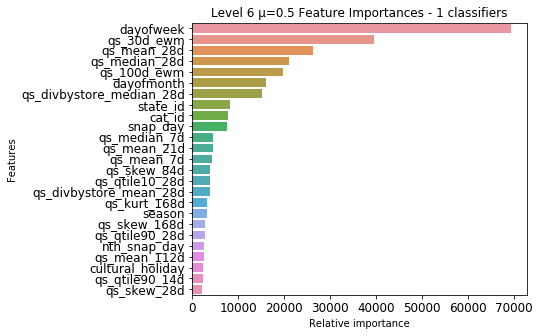

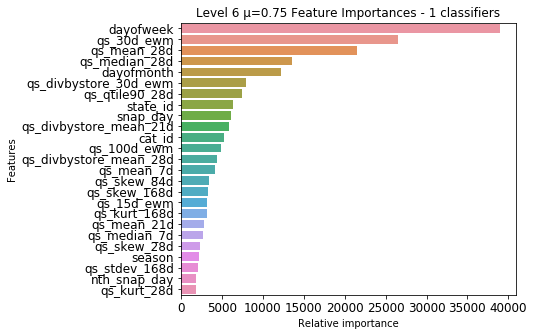

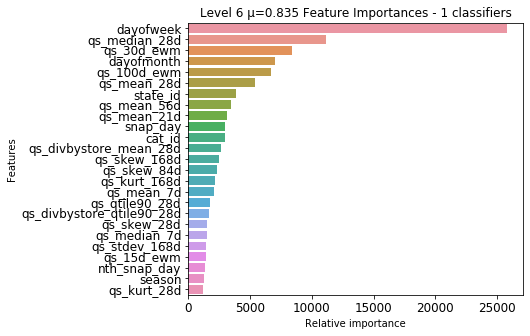

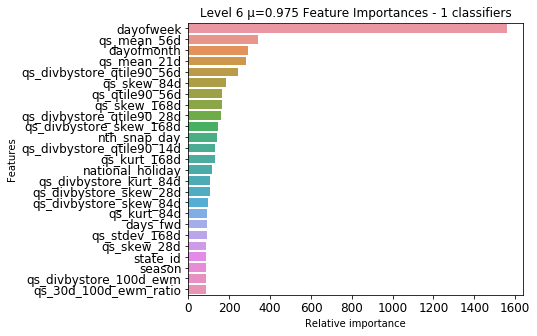

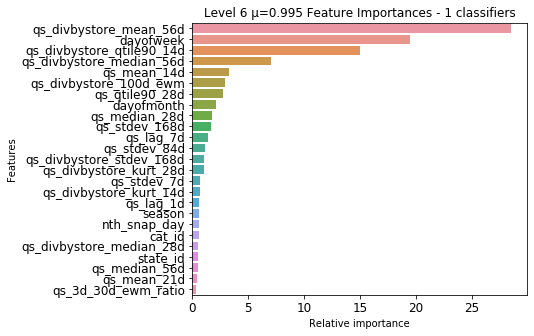

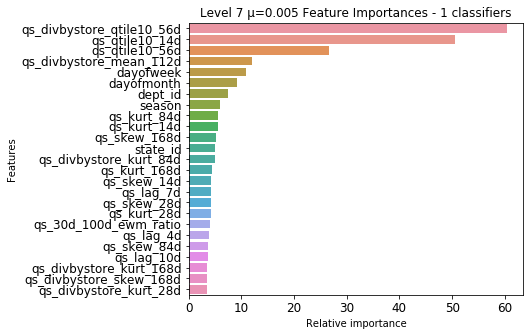

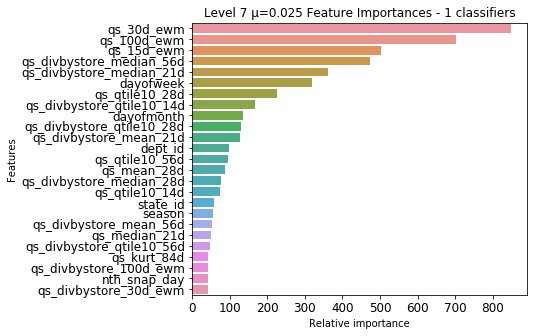

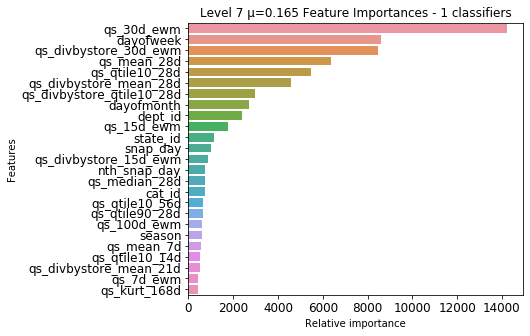

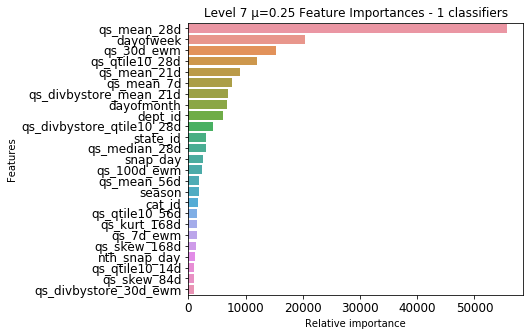

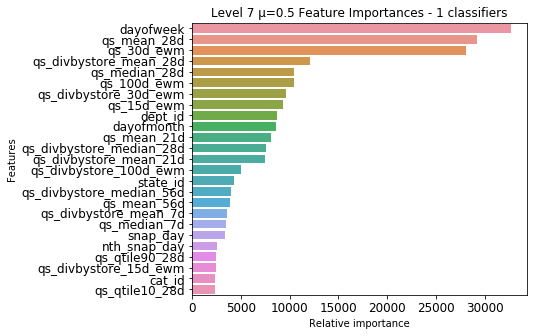

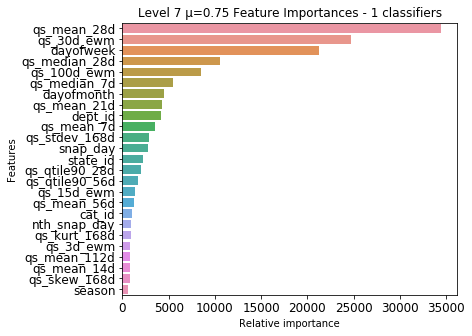

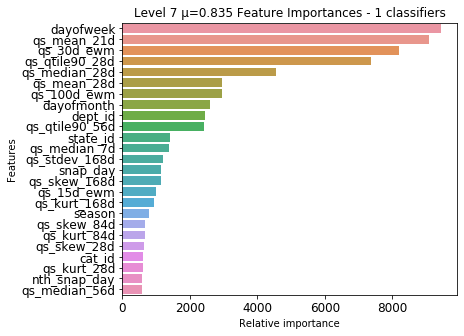

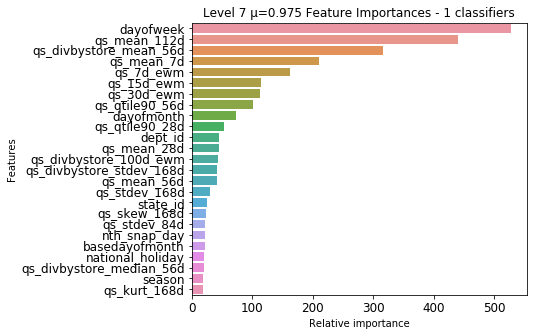

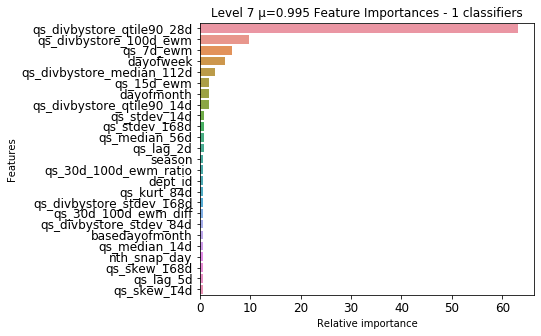

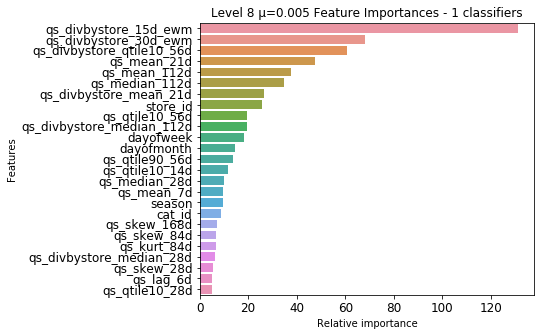

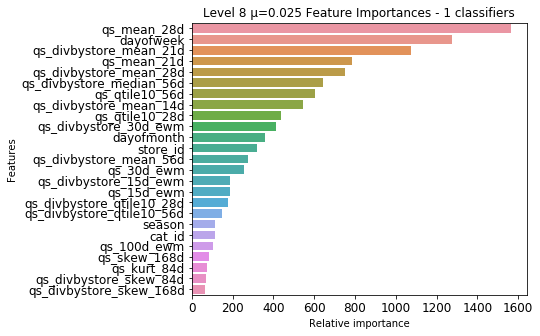

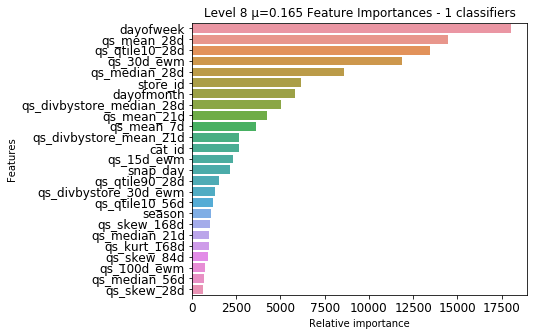

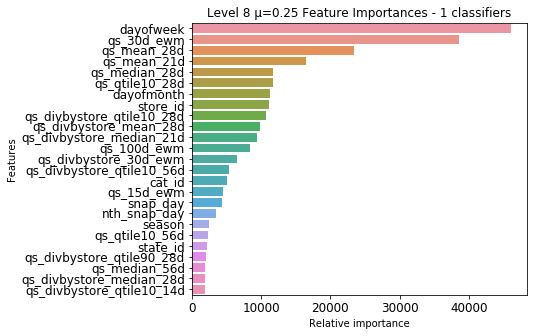

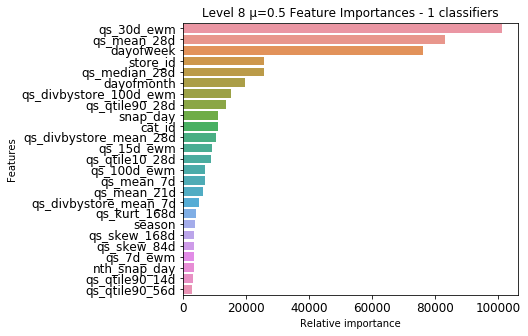

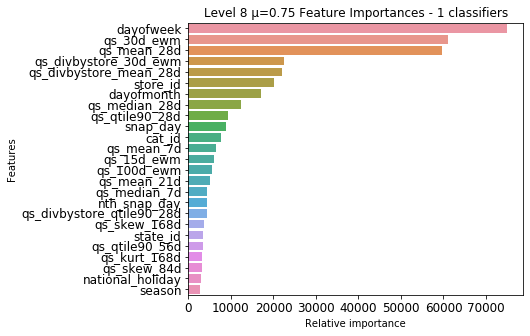

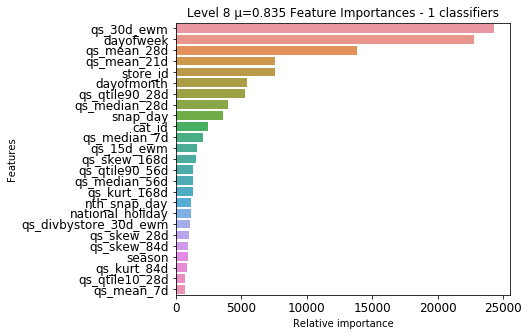

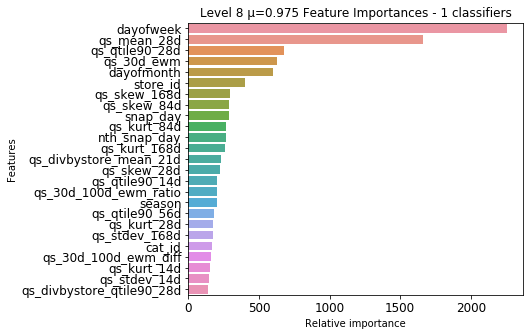

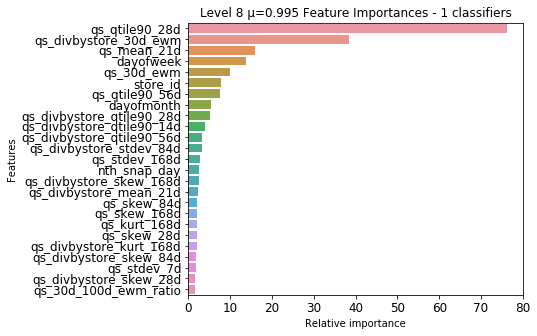

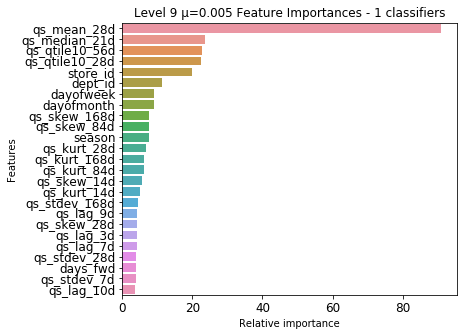

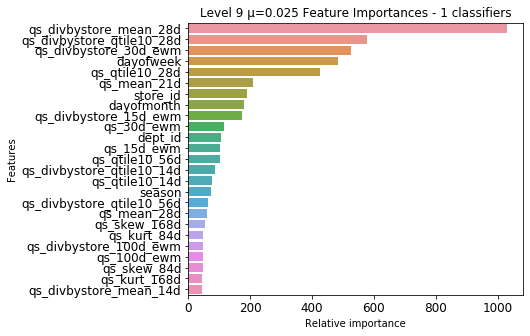

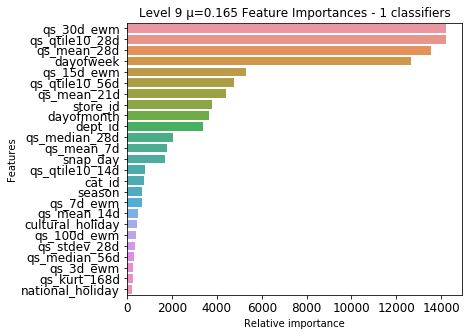

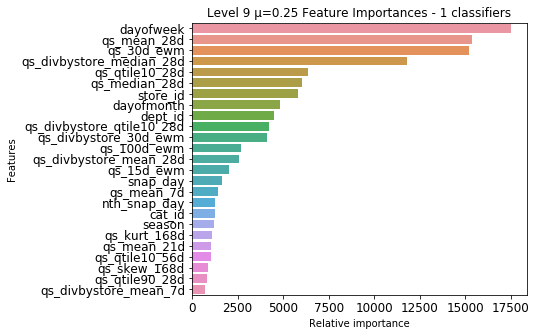

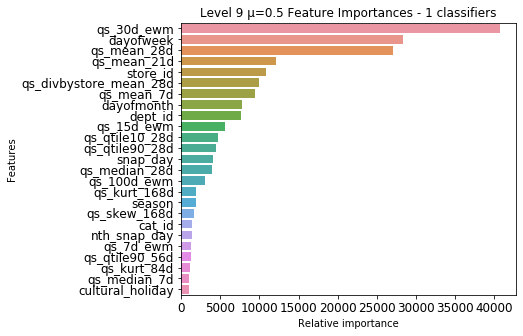

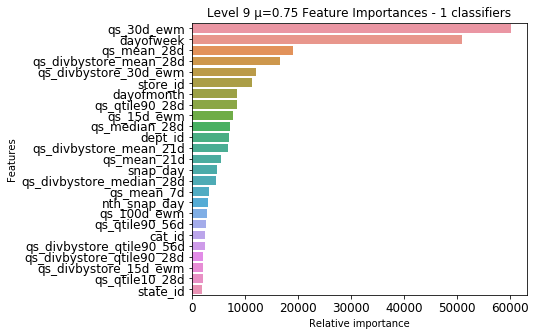

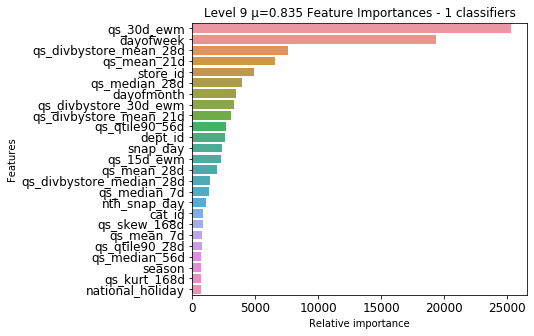

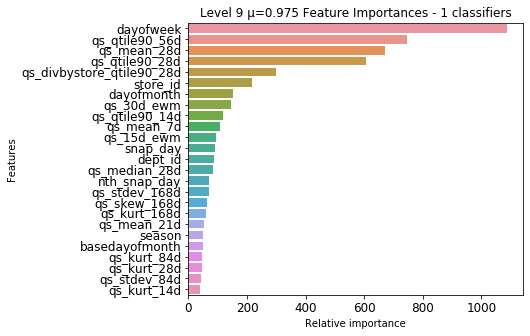

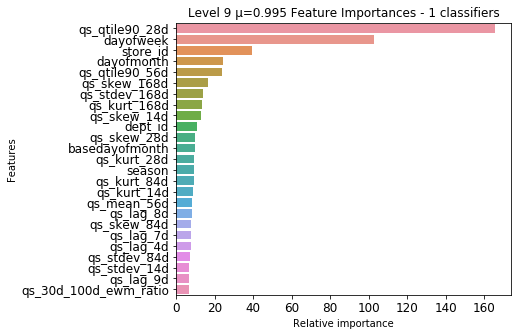

In [199]:
for level in sorted(clf_set.keys()):
    X = getSubsample(0.0001, level, 0.1)[0]
    print("Level {}:".format(level))
    for idx, q in enumerate(LEVEL_QUANTILES[level]):
        f = avg_FI([[q_clfs[idx] for clfs in clf_set[level] for q_clfs in clfs]], X.columns, 25, 
                       title = "Level {} \u03BC={} Feature Importances".format(level, q))
    print(); print()

In [200]:
ramCheck()

3.1 GB used


In [201]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  6431 s


### Predict

In [202]:
def avg(arr, axis = 0):
    return np.median(arr, axis = axis)

In [203]:
def predictSet(X, y, groups, scalers, clf_set):
    start_time = datetime.datetime.now(); 
    
    group_list = [*dict.fromkeys(groups)]   
    group_list.sort()
#     print(group_list)
    
    y_unscaled = y * scalers.scaler
    
    all_preds = []; ys=[]; gs = []; xs = []; scaler_stack = []
    if SINGLE_FOLD: group_list = group_list[-1:]
    for group_idx, group in enumerate(group_list):
        g = gc.collect()
        x_holdout = X[groups == group]
        y_holdout = y_unscaled[groups == group] 
        scalers_holdout = scalers[groups == group]
        groups_holdout = groups[groups == group]
        
        preds = np.zeros( (len(QUANTILES), len(y_holdout)), dtype=np.half)
        for q_idx, quantile in enumerate(QUANTILES):            
            q_preds = np.zeros( ( len(clf_set), len(y_holdout) ) )
            for bag_idx, clf in enumerate(clf_set):
                x_clean = x_holdout.drop(columns = [c for c in x_holdout.columns if c=='d' or c=='series'])
                if group_idx >= len(clf_set[bag_idx]): # if out of sample year, blend all years
                    qs_preds = np.zeros( (group_idx, len(x_clean)) )
                    for gidx in range(group_idx):
                        qs_preds[gidx, :] = clf_set[bag_idx][gidx][q_idx].predict(x_clean)
                    q_preds[bag_idx, :] = np.mean(qs_preds, axis = 0)
                else:
                    q_preds[bag_idx, :] = clf_set[bag_idx][group_idx][q_idx].predict(x_clean)
                
            q_preds = avg(q_preds) * scalers_holdout.scaler

            preds[q_idx, :] = q_preds
            
#             print(u"{} \u03BC={:.3f}: {:.4f}".format(group, quantile, quantile_loss(y_holdout, q_preds, quantile) ) )
        
        all_preds.append(preds)
        xs.append(x_holdout)
        ys.append(y_holdout)
        gs.append(groups_holdout)
        scaler_stack.append(scalers_holdout)
        print()
    y_pred = np.hstack(all_preds)
    scaler_stack = pd.concat(scaler_stack)
    y_true = pd.concat(ys)
    groups = pd.concat(gs)
    X = pd.concat(xs)
    
    end_time = datetime.datetime.now(); 
    print("Bag Prediction Time: {}".format(str(end_time - start_time).split('.', 2)[0] ))
    return y_pred, y_true, groups, scaler_stack, X

In [204]:
def predictOOS(X, scalers, clf_set, QUANTILES, validation = False):
    start_time = datetime.datetime.now(); 
    
    group_list = [1 + i for i in range(0, len(clf_set[0]))]   
    if validation:
        group_list = np.zeros(len(clf_set[0]))
        group_list[-1] = 1
    
    
    divisor = sum(group_list)
    print(np.round([g / divisor for g in group_list], 3)); print()
    
    x_holdout = X
    scalers_holdout = scalers 

    preds = np.zeros( (len(clf_set[0][0]), len(x_holdout)), dtype=np.float32)
    for q_idx in range( len(clf_set[0][0])): # loop over quantiles
        print(u'Predicting for \u03BC={}'.format( QUANTILES[q_idx]) )
        
        q_preds = np.zeros( ( len(clf_set), len(x_holdout) ), dtype = np.float32 )
        for bag_idx, clf in enumerate(clf_set):
            x_clean = x_holdout # .drop(columns = [c for c in x_holdout.columns if c=='d' or c=='series'])
            qs_preds = np.zeros( (len(group_list), len(x_clean)), dtype = np.float32 )
            if SINGLE_FOLD: group_list = group_list[-1:]
            for gidx in range(len(group_list)):
                if group_list[gidx] > 0: 
                    qs_preds[gidx, :] = clf_set[bag_idx][gidx][q_idx].predict(x_clean) * group_list[gidx] / divisor
            q_preds[bag_idx, :] = np.sum(qs_preds, axis = 0)

        q_preds = np.mean(q_preds, axis = 0) * scalers_holdout.scaler

        preds[q_idx, :] = q_preds
 
    end_time = datetime.datetime.now(); 
    print("Bag Prediction Time: {}".format(str(end_time - start_time).split('.', 2)[0] ))
    return preds

In [205]:
def wspl(true, pred, weights, trailing_vol, quantile = 0.5):
    loss = weights * np.where(true >= pred, 
                        quantile*(true-pred),
                        (1-quantile)*(pred - true) ) / trailing_vol
    return np.mean(loss) / np.mean(weights)   
 

### Random Sample Scoring

In [210]:
VALIDATION = -1

In [211]:
RSEED = 11

In [212]:
# number of samples for each data point;
N_REPEATS = 20 #if LE <15 else 10  

In [213]:
# clf_set

In [214]:
qls = {}; all_predictions = {}
for level in sorted(set(clf_set.keys()) & set(levels)):
    print("\n\n\nLevel {}\n\n\n".format(level))
    QUANTILES = LEVEL_QUANTILES[level]
    
    SS_FRAC, SCALE_RANGE = P_DICT[level] #  if level < 12 else ID_FILTER]; 
    SS_FRAC = SS_FRAC * SS_SS 
    EVAL_FRAC = SS_FRAC * (1 if level < 11 else 1/2) 
    EVAL_PWR = 0.6
    SCALE_RANGE_TEST = SCALE_RANGE
    
    np.random.seed(RSEED)
    X, y, groups, scalers = getSubsample(EVAL_FRAC * level_os[level] ** EVAL_PWR, level, 
                                         SCALE_RANGE_TEST, 
                                         n_repeats = N_REPEATS if level < 15 else N_REPEATS//2, 
                                         drops=False)
    if len(X) == 0:
        print("No Data for Level {}".format(level))
        continue;
        
    y_pred, y_true, groups, scaler_stack, X = predictSet(X, y, groups, scalers, clf_set[level]); 
   # assert (y_true == y.values * scalers.trailing_vol).all()

    predictions = pd.DataFrame(y_pred.T, index=y_true.index, columns = QUANTILES)
    predictions['y_true'] = y_true.values
    predictions = pd.concat((predictions, scaler_stack), axis = 'columns')
    predictions['group'] = groups.values
    predictions['series'] = X.series
    predictions['d'] = X.d
    predictions['days_fwd'] = X.days_fwd
    
    
    
    losses = pd.DataFrame(index=QUANTILES)
    for group in groups.unique():
        subpred = predictions[predictions.group == group]
        q_losses = []
        for quantile in QUANTILES:
            q_losses.append((quantile, wspl(subpred.y_true, subpred[quantile], 
                                  1, subpred.trailing_vol, quantile)))
        losses[group] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values
    qls[level] = [losses]    
    
    ramCheck()
    
    # now combine them
    predictions = predictions.groupby(['series', 'd', 'days_fwd']).agg(
                dict([(col, 'mean') for col in predictions.columns 
                          if col not in ['series', 'd', 'days_fwd']]\
                         + [('days_fwd', 'count')])  )\
            .rename(columns = {'days_fwd': 'ct'}).reset_index()
    predictions.head()
    predictions.sort_values('ct', ascending = False).head(5)
    print(len(predictions))
    
    all_predictions[level] = predictions




Level 1



1081 series that seek oversampling
56517     58.84375
56671     58.84375
56825     58.84375
54669     58.84375
166473    58.84375
Name: weights, dtype: float16
 scaled EWMS of extras:
165703    10.343750
166011    10.140625
166165    10.132812
166319    10.250000
166473    10.406250
dtype: float16
No State Ids
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:02:12
2.0 GB used
(1239500, 128)

Subsample Time: 0:02:14


Bag Prediction Time: 0:00:04
1.8 GB used
2084



Level 2



3243 series that seek oversampling
6156     14.289062
6618     14.289062
6310     14.289062
11084    14.289062
11238    14.304688
Name: weights, dtype: float16
 scaled EWMS of extras:
62520     9.781250
69142     9.937500
72222     9.968750
144140    9.132812
145064    9.234375
dtype: float16
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:05
1.9 GB

In [215]:
for level in sorted(all_predictions.keys()):
    predictions = all_predictions[level]
    
    losses = pd.DataFrame(index=LEVEL_QUANTILES[level])
    for group in groups.unique():
        subpred = predictions[predictions.group == group]
        q_losses = []
        for quantile in QUANTILES:
            q_losses.append((quantile, wspl(subpred.y_true, subpred[quantile], 
                                  subpred.ct, subpred.trailing_vol, quantile)))
        losses[group] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values
        
        
    qls[level] = [losses]
    
    print("\n\n\nLevel {} Year-by-Year OOS Losses for Evaluation Bag {}:".format(level, 1))
    print(losses); #print(); print()
        
#     print(BAGS)
#     print(SS_FRAC)
#     print(X.shape); #del X
#     print(SCALE_RANGE_TEST)
#     print(N_REPEATS)
    
    




Level 1 Year-by-Year OOS Losses for Evaluation Bag 1:
         2016
0.005  0.0091
0.025  0.0299
0.165  0.1163
0.250  0.1491
0.500  0.2033
0.750  0.1752
0.835  0.1465
0.975  0.0577
0.995  0.0115



Level 2 Year-by-Year OOS Losses for Evaluation Bag 1:
         2016
0.005  0.0108
0.025  0.0352
0.165  0.1486
0.250  0.1877
0.500  0.2394
0.750  0.2044
0.835  0.1655
0.975  0.0538
0.995  0.0170



Level 3 Year-by-Year OOS Losses for Evaluation Bag 1:
         2016
0.005  0.0183
0.025  0.0522
0.165  0.1691
0.250  0.2094
0.500  0.2569
0.750  0.2108
0.835  0.1713
0.975  0.0453
0.995  0.0156



Level 4 Year-by-Year OOS Losses for Evaluation Bag 1:
         2016
0.005  0.0105
0.025  0.0353
0.165  0.1382
0.250  0.1785
0.500  0.2195
0.750  0.1897
0.835  0.1575
0.975  0.0464
0.995  0.0138



Level 5 Year-by-Year OOS Losses for Evaluation Bag 1:
         2016
0.005  0.0128
0.025  0.0397
0.165  0.1587
0.250  0.1968
0.500  0.2543
0.750  0.2208
0.835  0.1831
0.975  0.0593
0.995  0.0203



Level 6 Year

In [251]:
# all_predictions[1][all_predictions[1].d == 1912].drop(columns = ['series', 'd', 'group', 'ct'])\
#     .set_index('days_fwd').plot()


In [217]:
# X.dayofweek

In [218]:
for level in sorted(all_predictions.keys()):
#     print("\nLevel {}:".format(level))
    predictions = all_predictions[level]

    predictions['future_d'] = predictions.d + predictions.days_fwd

    for quantile in QUANTILES:
        true = predictions.y_true
        pred = predictions[quantile]
        trailing_vol= predictions.trailing_vol

        predictions['loss_{}'.format(quantile)] = \
             np.where(true >= pred, 
                            quantile*(true-pred),
                            (1-quantile)*(pred - true) ) / trailing_vol

    predictions['loss'] = predictions[[c for c in predictions.columns if 'loss_' in str(c)]].sum(axis = 1)  
    predictions['wtg_loss'] = predictions.loss * predictions.ct / predictions.ct.mean()    

    # predictions.groupby('series').loss.sum()
    # predictions.groupby('series').wtg_loss.sum()
    # predictions.groupby('series').wtg_loss.sum().sum()

#     predictions.groupby(['series', 'd']).wtg_loss.sum().reset_index().pivot('d', 'series', values='wtg_loss').plot()

#     predictions.groupby(['series', 'd']).wtg_loss.sum().reset_index().pivot('d', 'series', values='wtg_loss')\
#             .ewm(span = 7).mean().plot();

#     (predictions.groupby(['series', 'future_d']).wtg_loss.sum().reset_index()\
#                 .pivot('future_d', 'series', values='wtg_loss').ewm(span = 7).mean() \
#     ).plot();

    # predictions.groupby(['series', 'future_d']).wtg_loss.sum().sort_values(ascending = False) #.ewm(span = 7).mean() \
    # ).plot();
    # predictions.groupby(['series', 'future_d']).wtg_loss.sum().sum()

#     predictions[(predictions.series == 0) & (predictions.days_fwd < 7 )].groupby('future_d').mean()\
#             [[c for c in predictions.columns if '.' in str(c) and 'loss' not in str(c)]]\
#                 .loc[1550:1700].plot(linewidth = 0.4)
#     train_flipped.iloc[:, 1].reset_index(drop=True).loc[1550:1700].plot( linewidth = 1);
    # train_flipped.iloc[active_days, 1].iloc[1000:].plot();

In [219]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  7223 s


In [220]:
ramCheck()

2.3 GB used


In [221]:
# memCheck()

### Make Submission

In [222]:
MEM_CAPACITY = 3e6  

In [223]:
MAX_RUNS = 2500 * (1/10 if SPEED or SUPER_SPEED else 1)
MIN_RUNS = 20 * (1/20 if SPEED or SUPER_SPEED else 1)

In [279]:
all_predictions = {}
for level in sorted(list(set(levels.unique()) & set(clf_set.keys()))):
    print('\n\nCreating Out-of-Sample Predictions for Level {}\n'.format(level))
    
    final_base = FINAL_BASE

    assert (final_base in ['d_1941', 'd_1913'])
    if final_base == 'd_1941':
        suffix = 'evaluation'
    elif final_base == 'd_1913':
        suffix = 'validation'
        
    print('   predicting 28 days forward from {}'.format(final_base))
    final_features = series_features[( series_features.d.map(cal_index_to_day) == final_base) & 
                                         (series_features.series.map(series_id_level) == level) ]

    print('    for {} series'.format(len(final_features)))
    
    SS_FRAC, SCALE_RANGE = P_DICT[level] # if level < 12 else ID_FILTER]; 
    SS_FRAC = SS_FRAC * 0.8
    print('   scale range of {}'.format(SCALE_RANGE))
    
    
    if level <= 9 or SPEED:
        X = []
        for df in range(0,28):
            Xi = final_features.copy()
            Xi['days_fwd'] = df + 1
            X.append(Xi)
        X = pd.concat(X, ignore_index = True); del Xi; del final_features;

        Xn = np.power(X.weights, 2)
        Xn = (Xn * MEM_CAPACITY / Xn.sum()).clip(MIN_RUNS, MAX_RUNS)
        Xn = (Xn * MEM_CAPACITY / Xn.sum()).clip(MIN_RUNS, MAX_RUNS)
        
        print('   average repeats: {:.0f}'.format(Xn.mean()))
        print('   median repeats: {:.0f}'.format(Xn.median()))
        print('   max repeats: {:.0f}'.format(Xn.max()))

        X = X.loc[np.repeat(Xn.index, Xn)]

        X, y, groups, scalers = getXYG(X, scale_range = SCALE_RANGE, oos = True)
        Xd = X.d;  Xseries = X.series
        X.drop(columns=['d', 'series'], inplace = True)

        print(X.shape)
        y_pred = predictOOS(X, scalers, clf_set[level], LEVEL_QUANTILES[level], suffix == 'validation'); print()

        predictions = pd.DataFrame(y_pred.T, index=X.index, columns = LEVEL_QUANTILES[level])
        predictions = pd.concat((predictions, scalers), axis = 'columns')
        predictions['series'] = Xseries
        predictions['d'] = Xd
        predictions['days_fwd'] = X.days_fwd.astype(np.int8)
        predictions['y_true'] = y * scalers.scaler
#         break;
        ramCheck()

        predictions = predictions.groupby(['series', 'd', 'days_fwd']).agg(
                        dict([(col, 'mean') for col in predictions.columns 
                                  if col not in ['series', 'd', 'days_fwd']]\
                                 + [('days_fwd', 'count')])  )\
                    .rename(columns = {'days_fwd': 'ct'}).reset_index()
        predictions.days_fwd = predictions.days_fwd.astype(np.int8)

    else: # levels 10, 11, 12
        
        predictions_full = []
        
        for df in range(0,28):
            print( '\n Predicting {} days forward from {}'.format(df + 1, final_base))
            X = final_features.copy()
            X['days_fwd'] = df + 1

            Xn = np.power(X.weights, 1.5)
            Xn = (Xn * MEM_CAPACITY / Xn.sum()).clip(MIN_RUNS, MAX_RUNS)
            Xn = (Xn * MEM_CAPACITY / Xn.sum()).clip(MIN_RUNS, MAX_RUNS)
            
            print('   average repeats: {:.0f}'.format(Xn.mean()))
            print('   median repeats: {:.0f}'.format(Xn.median()))
            print('   max repeats: {:.0f}'.format(Xn.max()))
            
            X = X.loc[np.repeat(Xn.index, Xn)]

            X, y, groups, scalers = getXYG(X, scale_range = SCALE_RANGE, oos = True)
            Xd = X.d;  Xseries = X.series
            X.drop(columns=['d', 'series'], inplace = True)

            print(X.shape)
            y_pred = predictOOS(X, scalers, clf_set[level], LEVEL_QUANTILES[level], suffix == 'validation'); print()

            predictions = pd.DataFrame(y_pred.T, index=X.index, columns = LEVEL_QUANTILES[level])
            predictions = pd.concat((predictions, scalers), axis = 'columns')
            predictions['series'] = Xseries
            predictions['d'] = Xd
            predictions['days_fwd'] = X.days_fwd.astype(np.int8)
            predictions['y_true'] = y * scalers.scaler

            ramCheck()

            predictions = predictions.groupby(['series', 'd', 'days_fwd']).agg(
                            dict([(col, 'mean') for col in predictions.columns 
                                      if col not in ['series', 'd', 'days_fwd']]\
                                     + [('days_fwd', 'count')])  )\
                        .rename(columns = {'days_fwd': 'ct'}).reset_index()
            predictions.days_fwd = predictions.days_fwd.astype(np.int8)
            predictions_full.append(predictions)
            
        predictions = pd.concat(predictions_full); del predictions_full
 
    all_predictions[level] = predictions; del predictions



Creating Out-of-Sample Predictions for Level 1

   predicting 28 days forward from d_1913
    for 1 series
   scale range of 0.7
   average repeats: 250
   median repeats: 250
   max repeats: 250
No State Ids
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
(7000, 126)
[1.]

Predicting for μ=0.005
Predicting for μ=0.025
Predicting for μ=0.165
Predicting for μ=0.25
Predicting for μ=0.5
Predicting for μ=0.75
Predicting for μ=0.835
Predicting for μ=0.975
Predicting for μ=0.995
Bag Prediction Time: 0:00:00

2.2 GB used


Creating Out-of-Sample Predictions for Level 2

   predicting 28 days forward from d_1913
    for 3 series
   scale range of 0.7
   average repeats: 250
   median repeats: 250
   max repeats: 250
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
(21000, 130)
[1.]

Predicting for μ=0.005
Predicting for μ=0.025
Pre

In [280]:
with open('all_predictions_raw.pkl', 'wb') as handle:
    pickle.dump(all_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [281]:
# all_predictions = pickle.load(open('../input/m5-submissions/all_predictions_valid_19.pkl', 'rb'))

In [282]:

losses = pd.DataFrame(index=LEVEL_QUANTILES[levels.min()])
for level in sorted(all_predictions.keys()):
    predictions = all_predictions[level]
    subpred = predictions
    q_losses = []
    for quantile in LEVEL_QUANTILES[level]:
        q_losses.append((quantile, wspl(subpred.y_true, subpred[quantile], 
                              subpred.weights, subpred.trailing_vol, quantile)))

#         print(np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values)
    losses[level] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values


#         print("\n\n\nLevel {} Year-by-Year OOS Losses for Evaluation Bag {}:".format(level, 1))
print(losses); print(); print()
print(losses.mean())
print(losses.mean().mean())

            1       2       3       4       5       6       7       8       9
0.005  0.0100  0.0112  0.0120  0.0118  0.0136  0.0117  0.0113  0.0121  0.0123
0.025  0.0318  0.0339  0.0422  0.0394  0.0421  0.0395  0.0439  0.0444  0.0483
0.165  0.1401  0.1332  0.1515  0.1451  0.1617  0.1612  0.1800  0.1803  0.2080
0.250  0.1731  0.1783  0.2012  0.1901  0.1933  0.2058  0.2274  0.2318  0.2637
0.500  0.2583  0.2243  0.2472  0.2205  0.2454  0.2546  0.2923  0.2833  0.3336
0.750  0.1968  0.1947  0.2026  0.1621  0.2238  0.1979  0.2572  0.2301  0.2816
0.835  0.1487  0.1660  0.1652  0.1336  0.2019  0.1605  0.2042  0.1833  0.2286
0.975  0.0741  0.0468  0.0464  0.0571  0.0625  0.0482  0.0642  0.0538  0.0629
0.995  0.0178  0.0140  0.0146  0.0177  0.0170  0.0128  0.0190  0.0158  0.0168


1    0.116744
2    0.111378
3    0.120322
4    0.108600
5    0.129033
6    0.121356
7    0.144389
8    0.137211
9    0.161756
dtype: float64
0.12786543209876544


### Level Harmonizer

In [283]:
a = pd.DataFrame(index = range(1, 29))
for level in sorted(all_predictions.keys()):
    if level > 9:
        continue;
    a[level] = all_predictions[level].groupby('days_fwd')[0.5].sum() / level_multiplier[level]


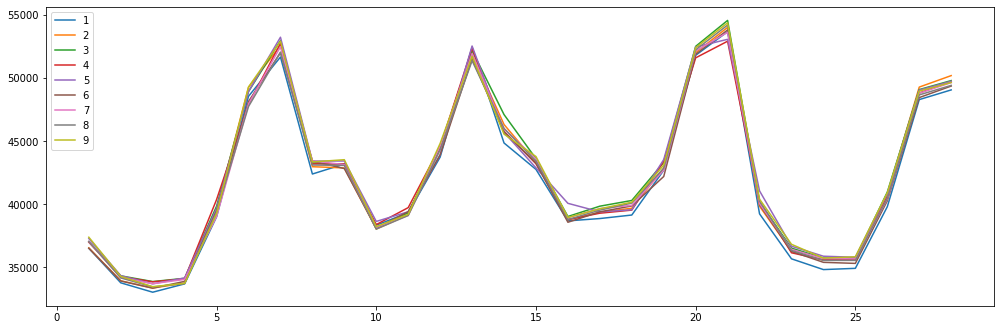

In [284]:
try:
    a.plot()
except:
    pass;

In [285]:
# all_predictions[level][quantile]

# all_predictions[level][quantile] * all_predictions[level].days_fwd.map(a.mean(axis=1) / a[level] )

In [286]:
ADJUSTMENT_FACTOR = 1 if SPEED or SUPER_SPEED else 0.7  # probably better as 1.0, but used 0.7 to be safe;

In [287]:
for level in sorted(all_predictions.keys()):
    if level > 9: 
        continue;
        
    for quantile in LEVEL_QUANTILES[level]:
        all_predictions[level][quantile] = all_predictions[level][quantile] \
                        * ( (1 - ADJUSTMENT_FACTOR) +
                              ADJUSTMENT_FACTOR * all_predictions[level].days_fwd.map(  a.mean(axis=1) / a[level] ) )

In [288]:
a = pd.DataFrame(index = range(1, 29))
for level in sorted(all_predictions.keys()):
    if level > 9:
        continue;
    a[level] = all_predictions[level].groupby('days_fwd')[0.5].sum() / level_multiplier[level]


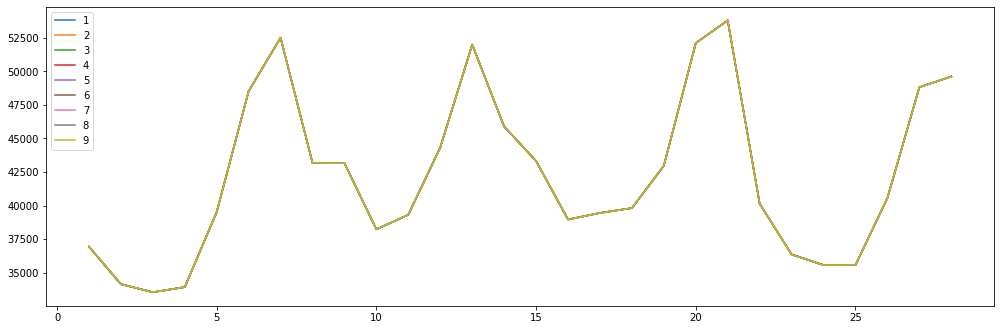

In [289]:
try:
    a.plot()
except:
    pass;

In [290]:

losses = pd.DataFrame(index=LEVEL_QUANTILES[level])
for level in sorted(all_predictions.keys()):
    predictions = all_predictions[level]
    subpred = predictions
    q_losses = []
    for quantile in LEVEL_QUANTILES[level]:
        q_losses.append((quantile, wspl(subpred.y_true, subpred[quantile], 
                              subpred.weights, subpred.trailing_vol, quantile)))

#         print(np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values)
    losses[level] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values


#         print("\n\n\nLevel {} Year-by-Year OOS Losses for Evaluation Bag {}:".format(level, 1))
print(losses); print(); print()
print(losses.mean())
print(losses.mean().mean())

            1       2       3       4       5       6       7       8       9
0.005  0.0095  0.0112  0.0122  0.0118  0.0138  0.0115  0.0113  0.0120  0.0124
0.025  0.0294  0.0339  0.0433  0.0395  0.0434  0.0388  0.0439  0.0441  0.0487
0.165  0.1256  0.1325  0.1570  0.1450  0.1685  0.1559  0.1794  0.1788  0.2102
0.250  0.1510  0.1779  0.2080  0.1904  0.2016  0.1987  0.2264  0.2296  0.2668
0.500  0.2141  0.2260  0.2583  0.2209  0.2494  0.2428  0.2899  0.2818  0.3366
0.750  0.1495  0.1947  0.2098  0.1576  0.2215  0.1928  0.2568  0.2295  0.2845
0.835  0.1210  0.1665  0.1724  0.1317  0.2002  0.1572  0.2038  0.1847  0.2306
0.975  0.0655  0.0498  0.0510  0.0540  0.0615  0.0483  0.0633  0.0551  0.0632
0.995  0.0173  0.0140  0.0151  0.0130  0.0165  0.0130  0.0190  0.0160  0.0173


1    0.098100
2    0.111833
3    0.125233
4    0.107100
5    0.130711
6    0.117667
7    0.143756
8    0.136844
9    0.163367
dtype: float64
0.1260679012345679


In [291]:
if suffix == 'validation':

    losses = pd.DataFrame(index=LEVEL_QUANTILES[level])
    for level in sorted(all_predictions.keys()):
        predictions = all_predictions[level]
        subpred = predictions
        q_losses = []
        for quantile in LEVEL_QUANTILES[level]:
            q_losses.append((quantile, wspl(subpred.y_true, subpred[quantile], 
                                  subpred.weights, subpred.trailing_vol, quantile)))
        
        losses[level] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values


#         print("\n\n\nLevel {} Year-by-Year OOS Losses for Evaluation Bag {}:".format(level, 1))
    print(losses); print(); print()
    print(losses.mean())

            1       2       3       4       5       6       7       8       9
0.005  0.0095  0.0112  0.0122  0.0118  0.0138  0.0115  0.0113  0.0120  0.0124
0.025  0.0294  0.0339  0.0433  0.0395  0.0434  0.0388  0.0439  0.0441  0.0487
0.165  0.1256  0.1325  0.1570  0.1450  0.1685  0.1559  0.1794  0.1788  0.2102
0.250  0.1510  0.1779  0.2080  0.1904  0.2016  0.1987  0.2264  0.2296  0.2668
0.500  0.2141  0.2260  0.2583  0.2209  0.2494  0.2428  0.2899  0.2818  0.3366
0.750  0.1495  0.1947  0.2098  0.1576  0.2215  0.1928  0.2568  0.2295  0.2845
0.835  0.1210  0.1665  0.1724  0.1317  0.2002  0.1572  0.2038  0.1847  0.2306
0.975  0.0655  0.0498  0.0510  0.0540  0.0615  0.0483  0.0633  0.0551  0.0632
0.995  0.0173  0.0140  0.0151  0.0130  0.0165  0.0130  0.0190  0.0160  0.0173


1    0.098100
2    0.111833
3    0.125233
4    0.107100
5    0.130711
6    0.117667
7    0.143756
8    0.136844
9    0.163367
dtype: float64


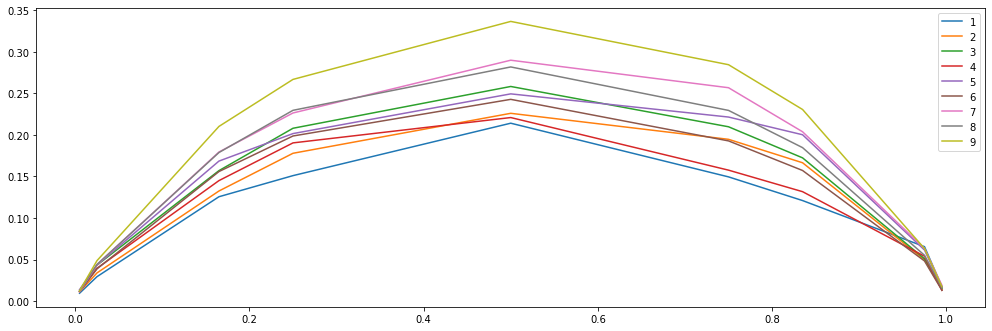

In [292]:
if suffix == 'validation':
    losses.plot()

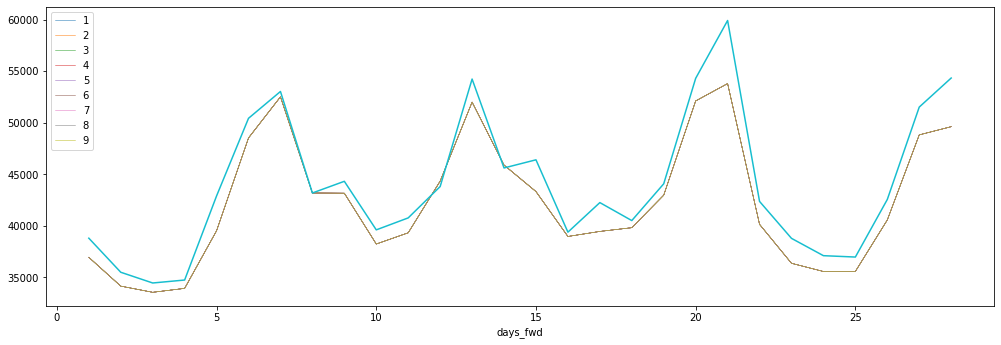

In [293]:
for level in sorted(all_predictions.keys()):
    predictions = all_predictions[level]
    (predictions.groupby('days_fwd')[0.5].sum() / level_multiplier[level]).plot(legend = True, 
                                                                                label = level,
                                                                               linewidth = 0.5)
    
if suffix=='validation':
    ( predictions.groupby('days_fwd').y_true.sum() / level_multiplier[level]) .plot(linewidth = 1.5)

In [294]:
train_flipped.shape

(1941, 154)

### Graphs

In [295]:
# (series_features[( series_features.d.map(cal_index_to_day) == final_base) & 
#                                          (series_features.series.map(series_id_level) == level) ]\
#         .sort_values('weights', ascending = False).reset_index().weights.astype(np.float32) ** 1.5).cumsum().plot()

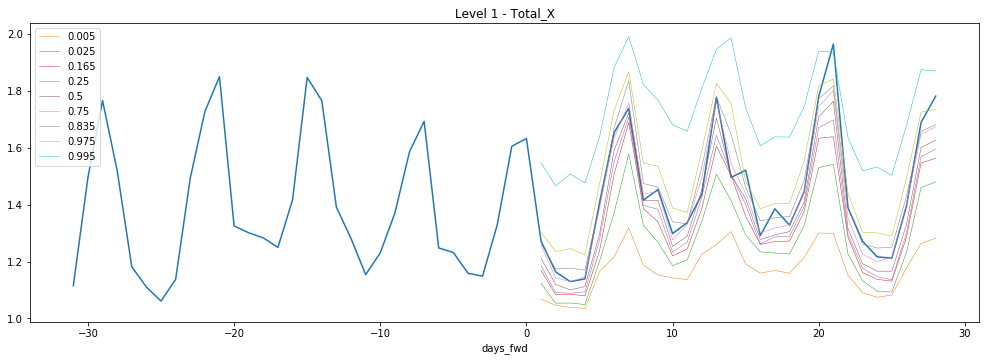

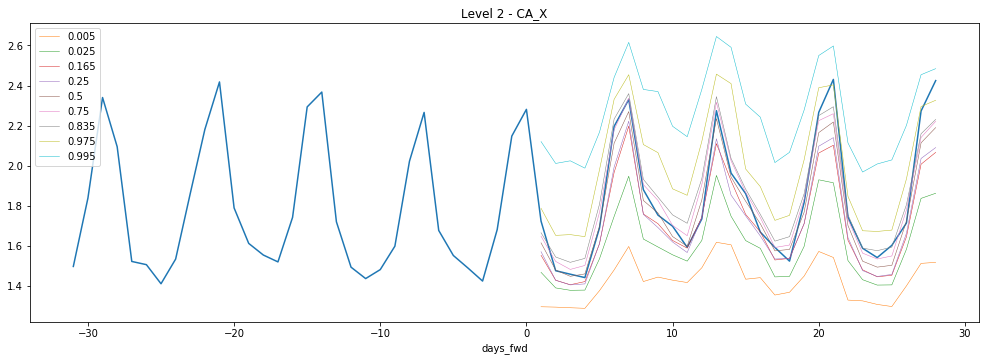

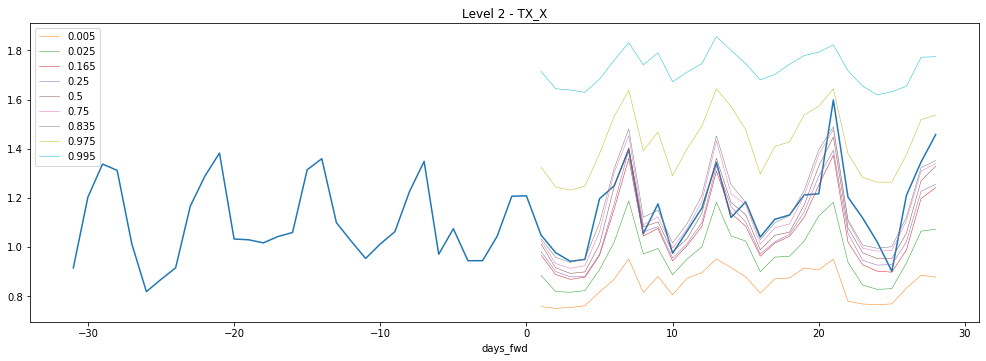

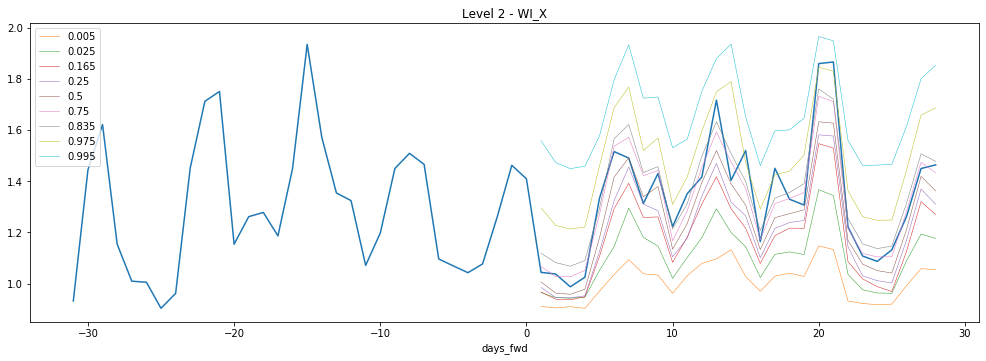

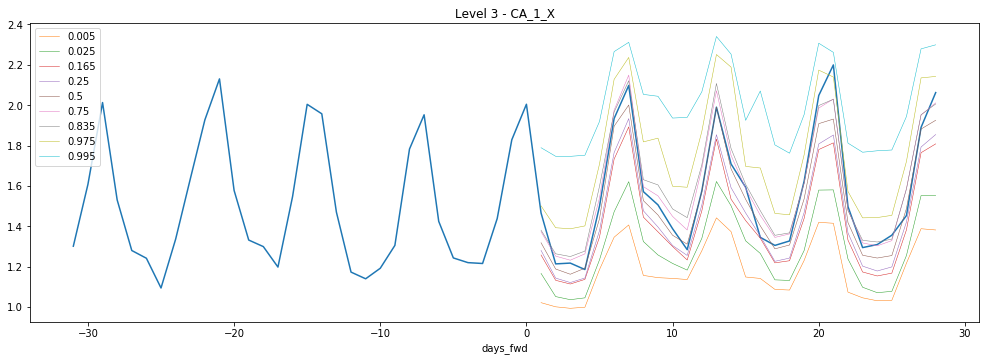

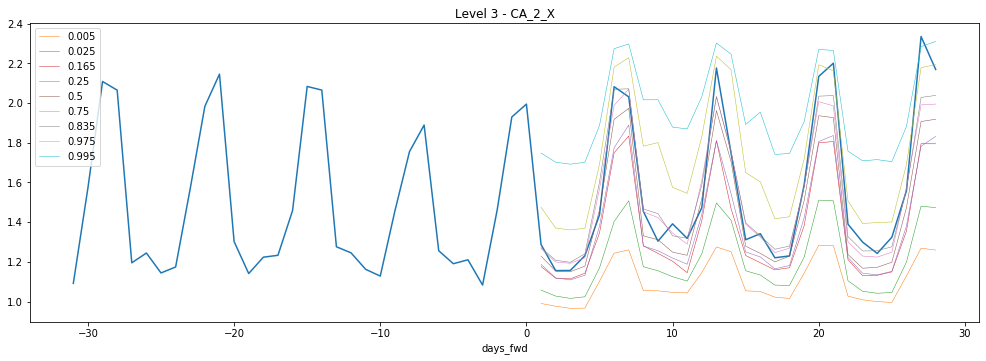

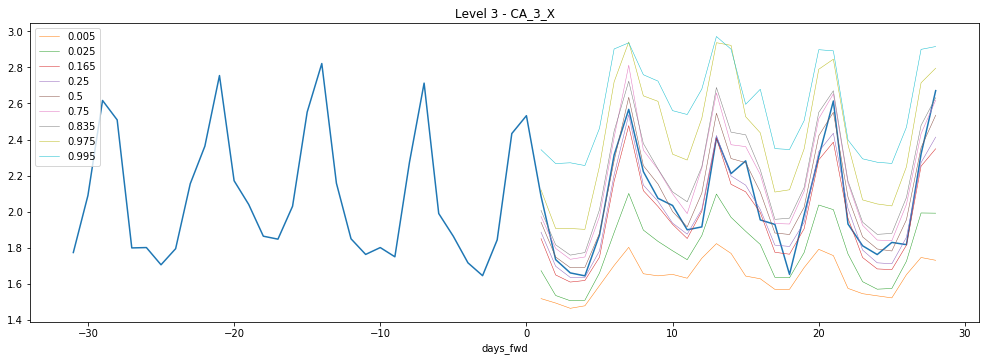

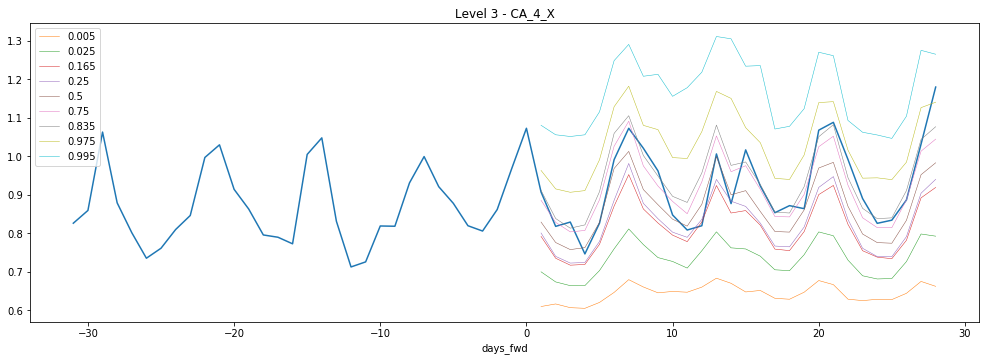

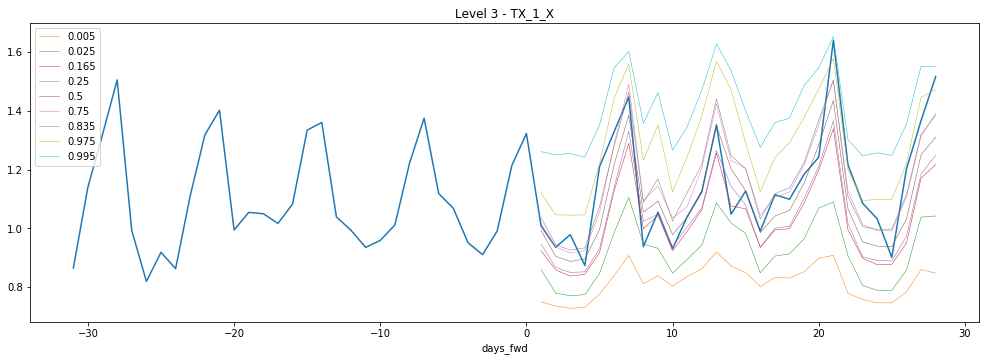

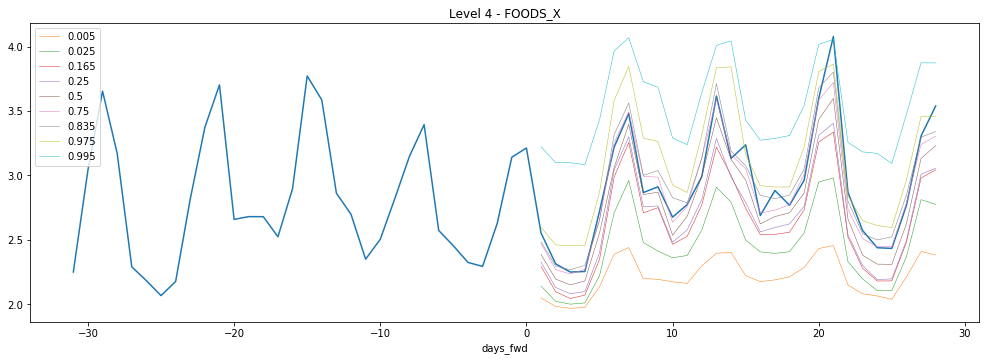

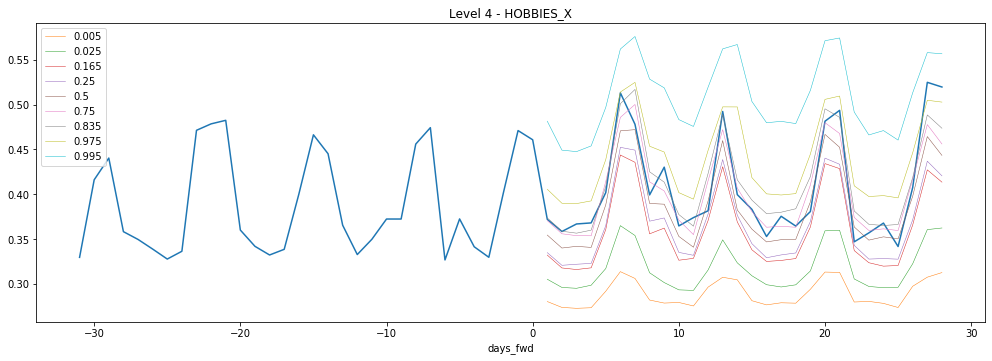

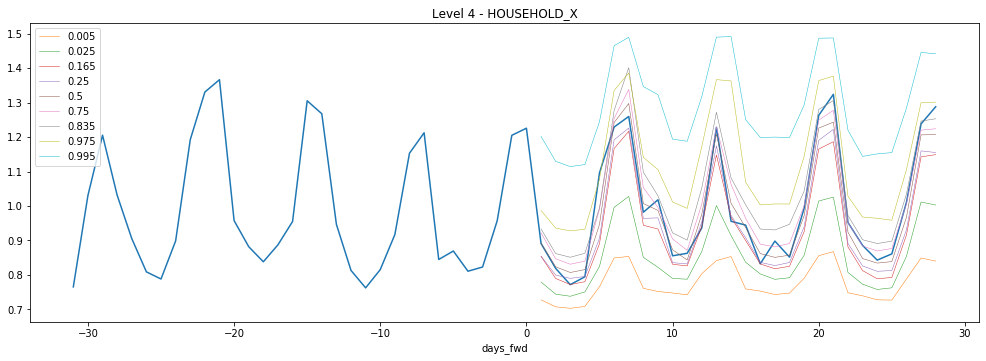

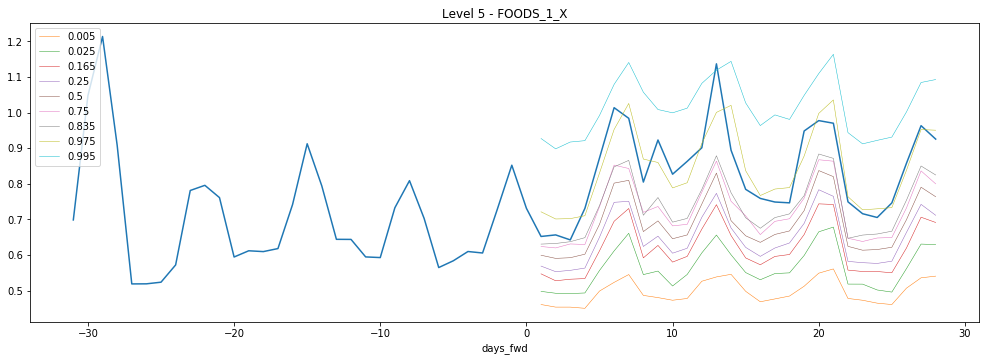

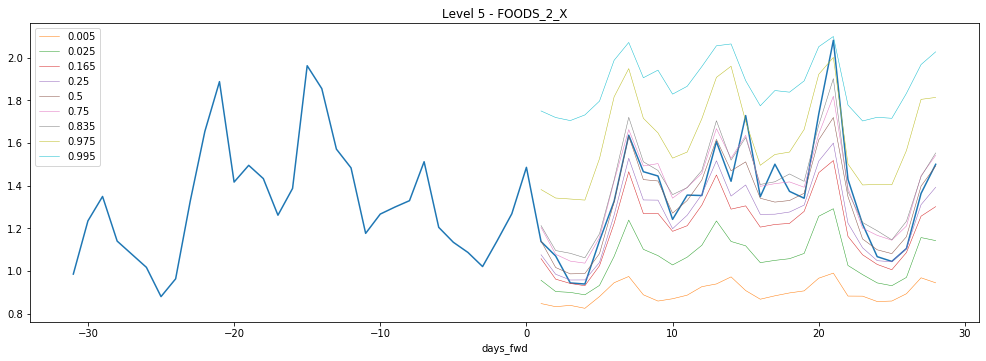

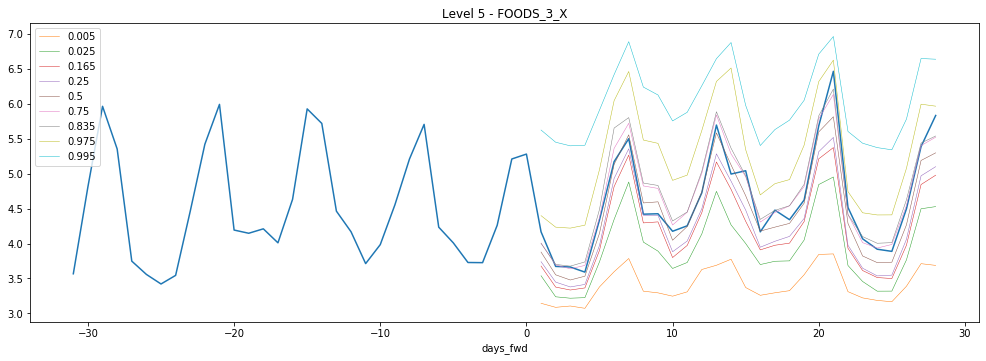

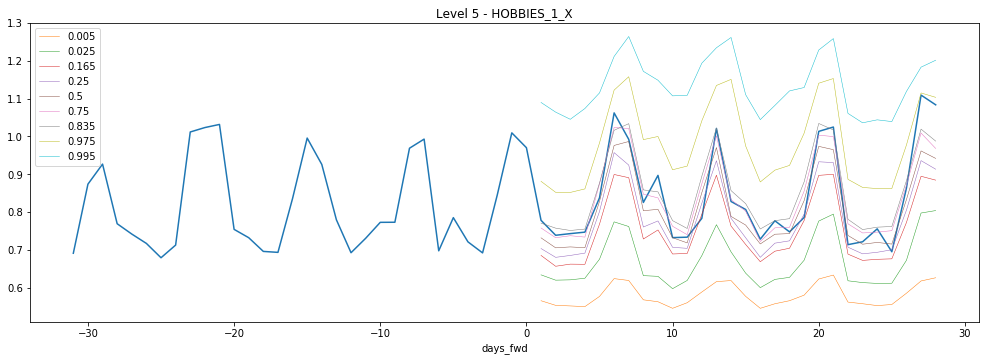

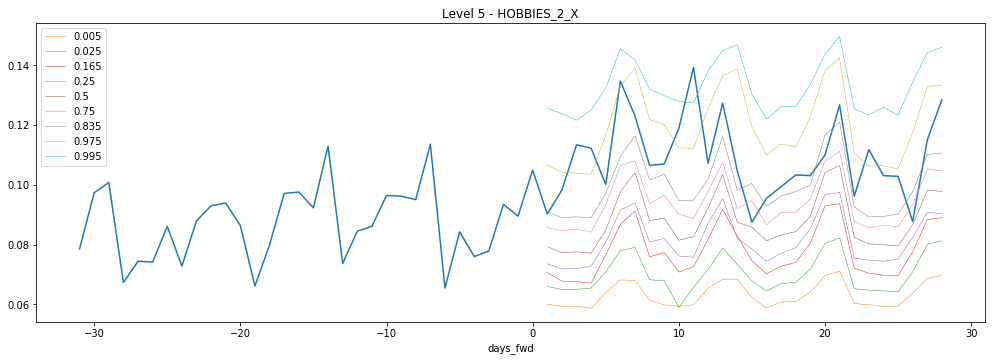

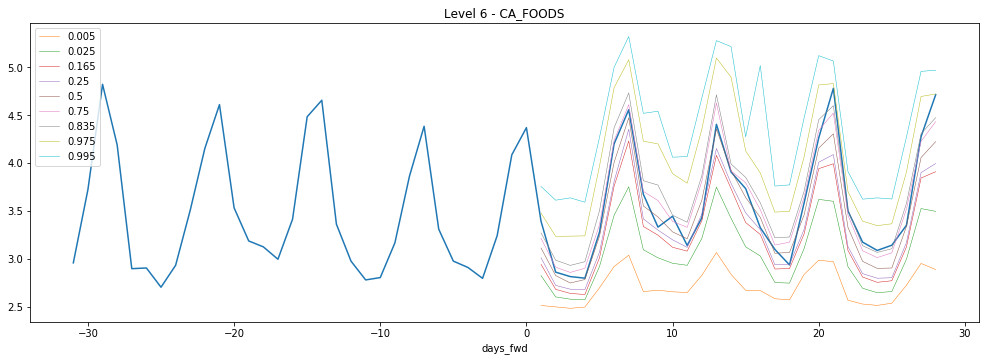

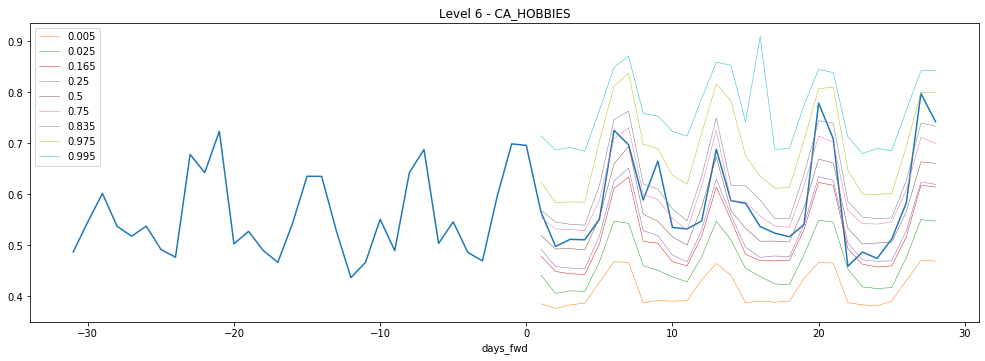

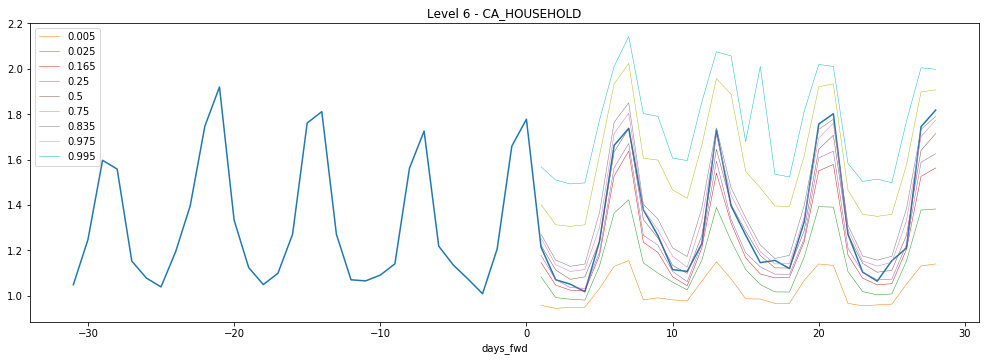

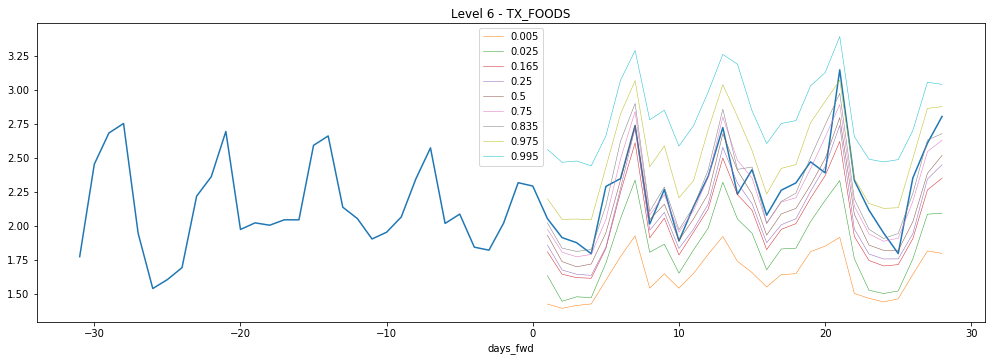

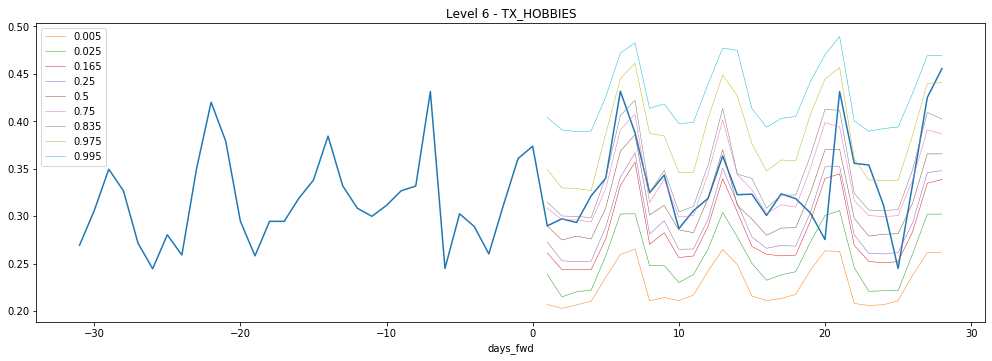

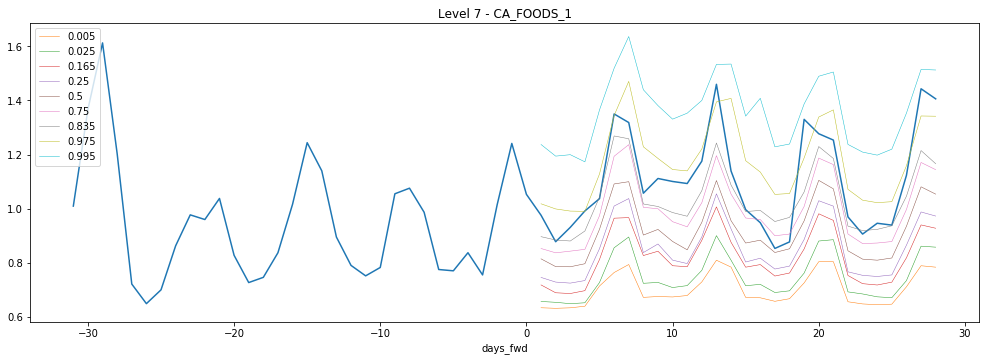

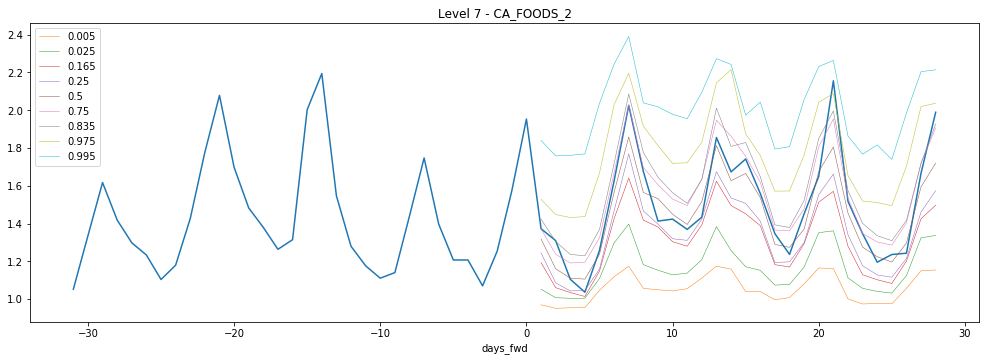

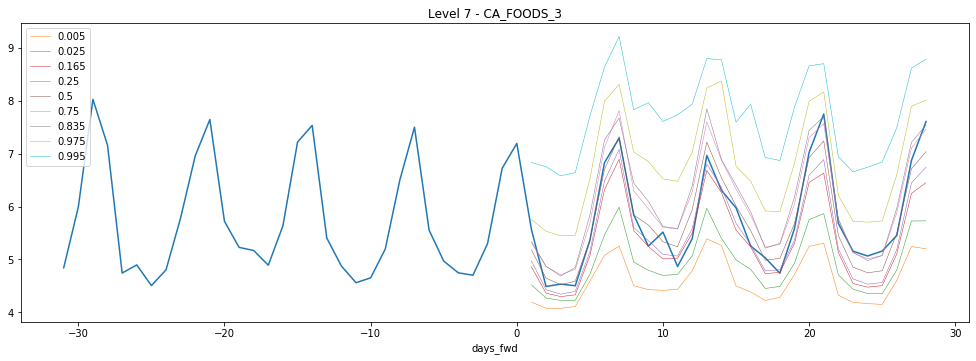

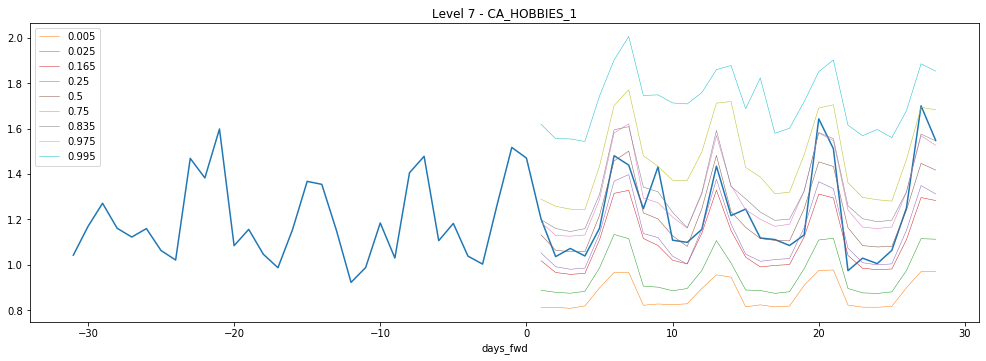

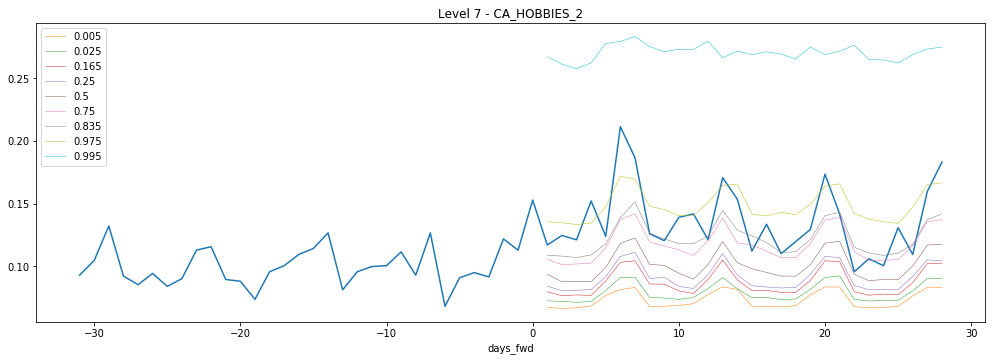

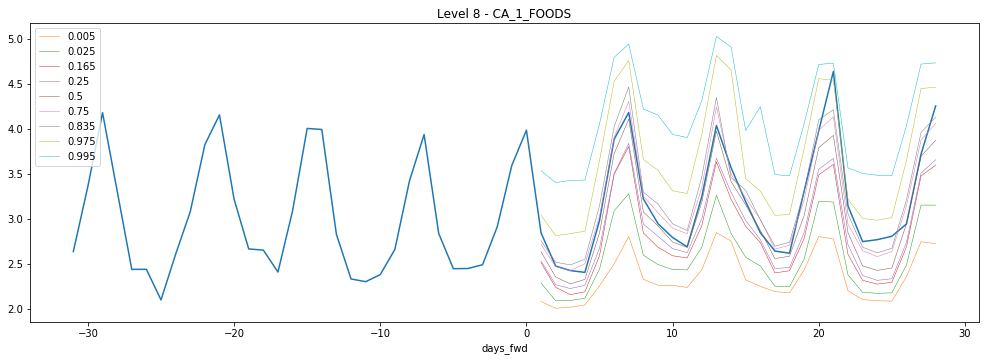

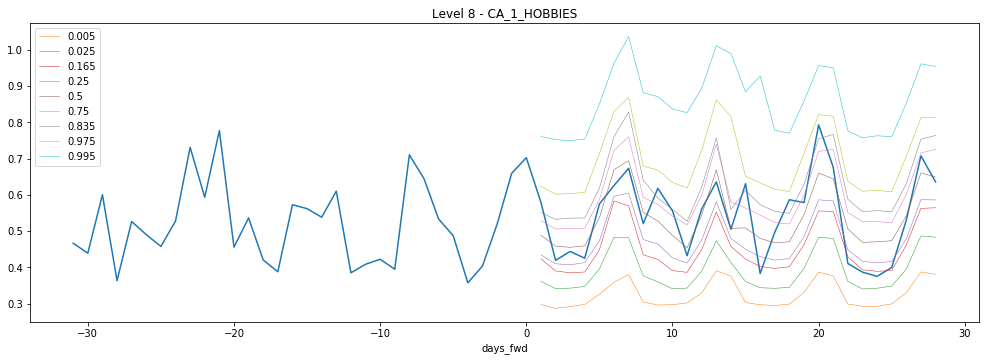

In [ ]:
for level in sorted(all_predictions.keys()):
    predictions = all_predictions[level]
    
    if level <= 9:
        series_list = predictions.series.unique()[:5]
    else:
        series_list =  series_features[( series_features.d.map(cal_index_to_day) == final_base) & 
                                         (series_features.series.map(series_id_level) == level) ]\
            .sort_values('weights', ascending = False).series.to_list()\
                 [:len(predictions.series.unique())//20 : len(predictions.series.unique()) // 500]
    
    for series in series_list:
        
        DAYS_BACK = 60
        if suffix == 'evaluation':
            prior = train_flipped.iloc[-DAYS_BACK:, series]
            prior.index = range(-DAYS_BACK + 1, 1 )
        else:
            prior = train_flipped.iloc[-DAYS_BACK:, series]
            prior.index = range(-DAYS_BACK + 28 + 1, 28 + 1 )
            
            
        f = prior.plot( linewidth = 1.5);

        f = predictions[predictions.series == series].set_index('days_fwd')\
                [[c for c in predictions.columns if c in LEVEL_QUANTILES[level]]].plot(
                                title = ("Level {} - {}".format(level, series_id_to_series[series])
                                      + ("" if level <=9 else " - weight of {:.2%}".format(
                                          predictions[predictions.series == series].weights.mean() )))
                                                       , 
                                              linewidth = 0.5, ax = f);
        f = plt.figure();
#     break;

In [ ]:
output_rows = []
for level in sorted(all_predictions.keys()):
    predictions = all_predictions[level]
    df = predictions[ ['series', 'days_fwd'] + list(LEVEL_QUANTILES[level])].copy()
    df.series = df.series.map(series_id_to_series)
    df = df.melt(['series', 'days_fwd'], var_name = 'q' )
    df.value = df.value / level_multiplier[level]
    df['name'] = df.series + '_' + df.q.apply(lambda x: '{0:.3f}'.format(x)) + '_' + suffix
    # df.days_fwd = 'F' + df.days_fwd.astype(str)

    for q in df.q.unique():
        qdf = df[df.q==q].pivot('name', 'days_fwd', 'value')
        qdf.columns = ['F{}'.format(c) for c in qdf.columns]
        qdf.index.name = 'id'
        output_rows.append(qdf)
    output = pd.concat(output_rows)

In [ ]:
output.tail()

In [ ]:
sample_sub.head()

In [ ]:
assert len(set(output.index) - set(sample_sub.id)) == 0

assert len(set(sample_sub.id) & set(output.index)) == len(output)

In [ ]:
output_file = ('submission_{}_lvl_{}.csv'.format(suffix, LEVEL) if MAX_LEVEL == None 
                                else 'submission_{}_lt_{}.csv'.format(suffix, MAX_LEVEL))

In [ ]:
output.round(3).to_csv(output_file)

In [ ]:
print(len(output) )

In [ ]:
output

In [ ]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')